# Predicting Sleep Variables in Mammals
### by Enzio M'Sihid, Aymen Dhaouadi, Mehdi Bennis and Estitxu Larralde Erasun

## Summary

### I. Introduction

### II. EDA - Exploratory Data Analysis
<blockquote>
        II.i  Preliminary Wrangling
</blockquote>
<blockquote>
        II.ii Univariate Exploration and Feature Engineering
</blockquote>
<blockquote>
        II.iii  Removing unnecessary columns
</blockquote>

### III. Model Training
<blockquote>
    III.i Model to predict 'Dreaming' variable
</blockquote>
<blockquote>
    III.ii Model to predict 'TotalSleep' variable
</blockquote>


***

## I. Introduction

This dataset contains data about 87 species of mammals, their sleeping attributes and their ecological and biological characteristics.

It contains 87 rows and 17 colonnes. It is therefore a small dataset (less than 100 observations).

## II. EDA - Exploratory Data Analysis

### II.i. Preliminary Wrangling

In [1]:
## Requirements file loading. You can use the following command to install the packages used when creating this notebook
#!pip install -r requirements.txt

#import all the libraries:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import plotly
import nbformat
import xgboost
import sklearn

import plotly.express as px
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode(connected = True) #Initiate notebook offline mode plots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

We check session information:

In [2]:
import session_info
session_info.show()


And create a requirements.txt file:

In [3]:
#!pipreqsnb --force . #The force destroys prior requirements.txt files

We load our data set into a dataframe. We create a copy of the raw data so the dataset is preserved regardless the modifications we do in the df dataframe.

In [4]:
file_path = "sleep_merged.csv"
df = pd.read_csv(file_path)
df_raw = df.copy()
df.head(5)

,Species,Genus,Order,Vore,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
0,African elephant,Loxodonta,Proboscidea,herbi,vu,6654.000,5712.0,3.3,20.7,NaN,NaN,38.6,645.0,3.0,5.0,3.0
1,African giant pouched rat,Cricetomys,Rodentia,omni,NaN,1.000,6.6,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0
2,African striped mouse,Rhabdomys,Rodentia,omni,NaN,0.044,0.0,8.7,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arctic fox,Vulpes,Carnivora,carni,NaN,3.380,44.5,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0
4,Arctic ground squirrel,Spermophilus,Rodentia,herbi,lc,0.920,5.7,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0


We start by an overview of the data.
First, we check the general attributes - the distribution of null values per column and the data type- using .info method:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Species       87 non-null     object 
 1   Genus         87 non-null     object 
 2   Order         87 non-null     object 
 3   Vore          87 non-null     object 
 4   Conservation  58 non-null     object 
 5   BodyWt        87 non-null     float64
 6   BrainWt       87 non-null     float64
 7   TotalSleep    87 non-null     float64
 8   Awake         87 non-null     float64
 9   NonDreaming   47 non-null     float64
 10  Dreaming      63 non-null     float64
 11  LifeSpan      54 non-null     float64
 12  Gestation     54 non-null     float64
 13  Predation     58 non-null     float64
 14  Exposure      58 non-null     float64
 15  Danger        58 non-null     float64
dtypes: float64(11), object(5)
memory usage: 11.0+ KB


We continue the overview by having a look into the main statistical attributes of all the numerical columns:

In [6]:
df.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
count,87.000000,87.000000,87.000000,87.000000,47.000000,63.000000,54.000000,54.000000,58.000000,58.000000,58.000000
mean,161.384310,196.405287,10.608046,13.393103,8.736170,1.979365,20.240741,139.268519,2.844828,2.362069,2.586207
std,768.846727,793.628150,4.465793,4.467481,3.679522,1.474204,18.757011,144.696322,1.496214,1.575005,1.426989
min,0.005000,0.000000,1.900000,4.100000,2.100000,0.100000,2.000000,12.000000,1.000000,1.000000,1.000000
25%,0.202500,0.000000,8.150000,10.250000,6.300000,0.900000,6.125000,36.750000,2.000000,1.000000,1.000000
50%,2.000000,5.500000,10.300000,13.700000,8.400000,1.800000,15.100000,79.000000,3.000000,2.000000,2.000000
75%,43.165000,64.000000,13.750000,15.850000,11.000000,2.500000,28.000000,195.000000,4.000000,4.000000,4.000000
max,6654.000000,5712.000000,19.900000,22.100000,17.900000,6.600000,100.000000,645.000000,5.000000,5.000000,5.000000


As we can observe, this is a relatively small data set with only 87 events. 

There are many null values in over half of the columns. In a sample of this size, this could compromise the accuracy of the data model and its relevance. For a bigger dataset, we might have dropped all the rows with null values. In this case, we rather find another solution to avoid reducing the size of the sample any further.

The minimum and maximum values are far from the mean and median for several columns. As for these two statistics, they are very different for columns BodyWt, BranWt, LifeSpan and Gestation, which implies very likely having outliers or at least very heterogeneous distributions.

Besides, we observe that the minimum value for BrainWt is 0. This is an issue we will look into later on in our analysis.

It would be interesting to evaluate the correlation between both, TotalSleep and Dreaming, and the rest of variables. Then we will be able to determine which of them we should consider to build a predicting model for the sleeping attributes (TotalSleep, Dreaming).

For now we will have a more specific look into the number of null values per column before proceeding to a Univariate analysis of the columns :


In [7]:
#Let's check the specific NaN values count
df.isna().sum()

Species          0
Genus            0
Order            0
Vore             0
Conservation    29
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming     40
Dreaming        24
LifeSpan        33
Gestation       33
Predation       29
Exposure        29
Danger          29
dtype: int64

Now that we have an overview of the null values, we would like to check if there is no negative values or zeros. Let's start by the negative values:

In [8]:
# Create df_temp excluding the first 5 columns of df which contains str
df_temp = df.select_dtypes(include=['number'])

# Count negative values in each column separately
negative_counts_per_column = {}

for column in df_temp.columns:
    negative_counts_per_column[column] = (df_temp[column] < 0).sum()

print(negative_counts_per_column)

{'BodyWt': 0, 'BrainWt': 0, 'TotalSleep': 0, 'Awake': 0, 'NonDreaming': 0, 'Dreaming': 0, 'LifeSpan': 0, 'Gestation': 0, 'Predation': 0, 'Exposure': 0, 'Danger': 0}


• We don't have any negative values

Let's find out about the zero values:

In [9]:
# We first select specified columns for df_temp
df_temp = df[['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming', 'LifeSpan', 'Gestation', 'Predation', 'Exposure', 'Danger']]

# Then count zero values in each column separately
zero_counts_per_column = {}

for column in df_temp.columns:
    zero_counts_per_column[column] = (df_temp[column] == 0).sum()

print(zero_counts_per_column)

{'BodyWt': 0, 'BrainWt': 23, 'TotalSleep': 0, 'Awake': 0, 'NonDreaming': 0, 'Dreaming': 0, 'LifeSpan': 0, 'Gestation': 0, 'Predation': 0, 'Exposure': 0, 'Danger': 0}


• Everything is fine except that we have 23x 0 values in BrainWt. 

We will have to solve the issue as this is a important variable. We'll take care of it in the next section, when we explore each attribute one by one.

## II.ii Univariate Exploration

In this section, we investigate the distributions of individual variables and see if a deeper look is needed to clean things up.

## Vore

This attribute concerns the diet of the mammals:

In [10]:
#Let's check the specific Vore we have
df.Vore.value_counts()

Vore
herbi      37
carni      22
omni       20
insecti     8
Name: count, dtype: int64

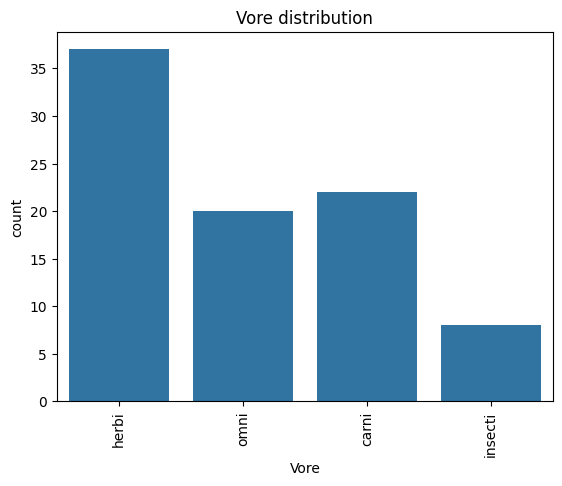

In [11]:
base_color= sns.color_palette()[0]
sns.countplot(data=df, x='Vore', color=base_color)
plt.title('Vore distribution')
plt.xticks(rotation=90);

We have more "herbi" in the data set and not many "insecti" which might be a source of bias.

"Vore" seems to be the easiest column to decompose our data set. Let's encode it right away so that we can better manipulate it later on.



Let's have a quick look to the distribution of vores regarding sleeping habits. First, the TotalSleep:

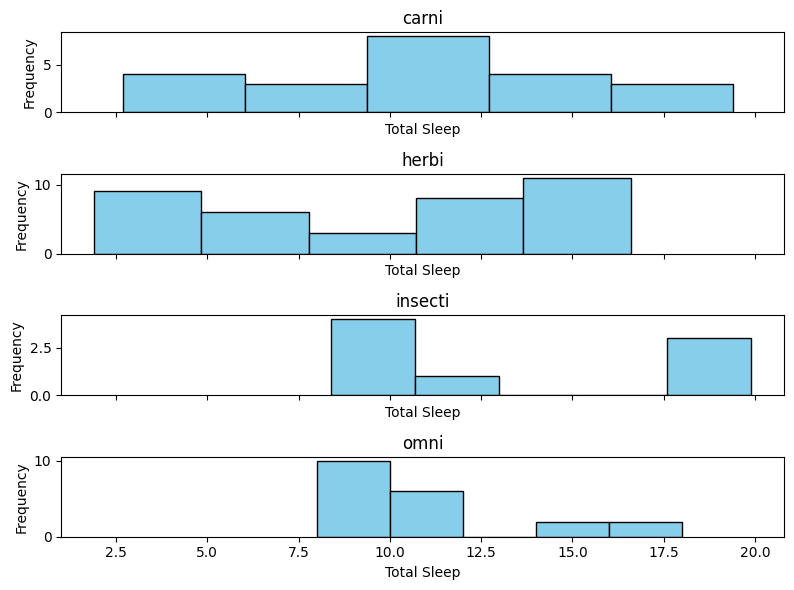

In [12]:
# We split the DataFrame based on the unique values in the "Vore" column
groups = df.groupby("Vore")

# Then create subplots for each facet
fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(8, 6), sharex=True)

# Plot histograms for each facet
for i, (vore, data) in enumerate(groups):
    ax = axes[i]
    ax.hist(data["TotalSleep"], bins=5, color='skyblue', edgecolor='black')
    ax.set_title(vore)
    ax.set_xlabel("Total Sleep")
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

Second, let's check the distribution of "vore" vs. "Dreaming" (how long they dream):

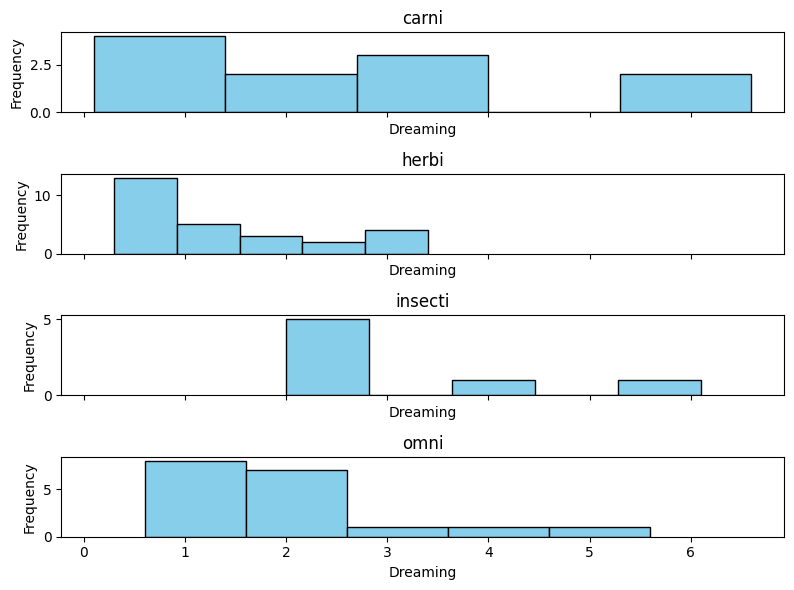

In [13]:
# We split the DataFrame based on the unique values in the "Vore" column
groups = df.groupby("Vore")

# Then create subplots for each facet
fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(8, 6), sharex=True)

# Plot histograms for each facet
for i, (vore, data) in enumerate(groups):
    ax = axes[i]
    ax.hist(data["Dreaming"], bins=5, color='skyblue', edgecolor='black')
    ax.set_title(vore)
    ax.set_xlabel("Dreaming")
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

We don't notice profound differences in repartition between the vores. We see that "carni" seem to sleep longuer than "herbi" but due to size of the sample (or lack of data) we can't be sure that there is a significative difference.


As mentioned before, we have decided to encode vore for an easier manipulation.

In [14]:
#Let's encode Vore
df = pd.get_dummies(df, columns=['Vore'], dtype=int)

# Remove the prefix from the column names of Vore
df.columns = df.columns.str.replace('Vore_', '')

df.head(5)

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
0,African elephant,Loxodonta,Proboscidea,vu,6654.000,5712.0,3.3,20.7,NaN,NaN,38.6,645.0,3.0,5.0,3.0,0,1,0,0
1,African giant pouched rat,Cricetomys,Rodentia,NaN,1.000,6.6,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0,0,0,0,1
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.0,8.7,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
3,Arctic fox,Vulpes,Carnivora,NaN,3.380,44.5,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0,1,0,0,0
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.7,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0,0,1,0,0


## Order

An order is a rank used in the biological taxonomy. Each order is split into families. There are many orders in each class. A group of closely related families forms an order. Let's see the distribution of "order":

In [15]:
df.Order.value_counts()

Order
Rodentia           22
Carnivora          14
Primates           13
Artiodactyla        6
Soricomorpha        5
Hyracoidea          3
Cetacea             3
Perissodactyla      3
Didelphimorphia     3
Diprotodontia       2
Proboscidea         2
Cingulata           2
Erinaceomorpha      2
Chiroptera          2
Lagomorpha          1
Monotremata         1
Afrosoricida        1
Pilosa              1
Scandentia          1
Name: count, dtype: int64

 • The Data Set has a big bias regarding Rodentias.

As "herbi" is the most common "vore" group, let's have a look into the number of "rodentia" that are also "herbi" (i.e. herbivore rodents).

In [16]:
# Let's check bias for herbi rodents
df[(df.Order == 'Rodentia') & (df.herbi == 1)].shape[0]

18

•  This means that out of the 87 observations, 18 are herbivore rodents (i.e. over 20.5%), which adds to the bias of the dataset.

•  Besides the "rodentia", "carnivora" and "primates", the rest of "order" groups are very small (i.e. most of the groups have only 1 to 3 observations).

## Genus

Genus is another rank in biological taxonomy. Genus is a very close relation — the species share a common ancestor that is relatively recent. 

In [17]:
df["Genus"].value_counts()

Genus
Spermophilus    3
Panthera        3
Equus           2
Vulpes          2
Canis           2
               ..
Priodontes      1
Genetta         1
Galago          1
Erinaceus       1
Eutamias        1
Name: count, Length: 80, dtype: int64

• As this attribute refers to species that are really close from each other, there are also as many as different species/events in the dataset : 80 different values out of 87. There's no point in encoding it and we might as well drop the column.

## Species 

This is most probably the most atomic of the attributes:

In [18]:
df.Species.value_counts()
#df = df.drop(["Species"],axis=1)

Species
African elephant             1
Northern fur seal            1
Potto                        1
Potoroo                      1
Pilot whale                  1
                            ..
Genet                        1
Galago                       1
European hedgehog            1
Eastern american mole        1
Western american chipmunk    1
Name: count, Length: 87, dtype: int64

• 87 different values

• But some have similar names (fox, mouse, seals...)

• It might be interesting to see if by grouping the species by similar names, we get a more homogeneous data set. Let's have a look:

In [19]:
# Create new columns 'Animal_Name', 'Attributes', and 'Area'
df['Animal_Name'] = ""
df['Attributes'] = ""
df['Area'] = ""

# Split the 'Species' column based on the number of words
for index, row in df.iterrows():
    species = row['Species']
    words = species.split()
    num_words = len(words)
    if num_words == 1:
        df.at[index, 'Animal_Name'] = words[0]
    elif num_words == 2:
        df.at[index, 'Area'] = words[0]
        df.at[index, 'Animal_Name'] = words[1]
    elif num_words == 3:
        df.at[index, 'Area'] = words[0]
        df.at[index, 'Attributes'] = words[1]
        df.at[index, 'Animal_Name'] = words[2]
    elif num_words >= 4:
        df.at[index, 'Area'] = words[0]
        df.at[index, 'Attributes'] = words[1]
        df.at[index, 'Animal_Name'] = ' '.join(words[2:])

In [20]:
# The Area is not meaningful.
df.drop(columns=['Area'], inplace=True)

In [21]:
#The Attributes are not meaningful either
df.drop(columns=['Attributes'], inplace=True)

In [22]:
df["Animal_Name"].value_counts()

Animal_Name
mouse          5
shrew          4
monkey         3
squirrel       3
rat            3
              ..
pouched rat    1
pig            1
Horse          1
Human          1
opossum        1
Name: count, Length: 63, dtype: int64

 • We still have a lot of different Animal names, and there's no evidence that within a same species, sleeping and dreaming attributes are useful but it is still a better column than species. We might use it but in the end we won't encode it.

## New column: Family

In an effort to add a less atomized column to the dataset than Genus or Species, we checked the 'Family' taxonomic category for each of the data sample observations:

In [23]:
df_f = pd.read_excel("sleep-merged-family.xlsx")

Let's check the distinct values of the column:

In [24]:
distinct_values_count = df_f["Family"].nunique()

print("Distinct values count:", distinct_values_count)

Distinct values count: 32


There are too many different values in the column. Let's double check using value_counts method:


In [25]:
df_f["Family"].value_counts()

Family
Felidae             4
Muridae             4
Hominidae           3
Canidae             3
Sciuridae           3
Soricidae           3
Cricetidae          3
Equidae             2
Erinaceidae         2
Bovidae             2
Elephantidae        2
Phocidae            2
Vespertilionidae    2
Cercopithecidae     2
Chlamyphoridae      1
Spalacidae          1
Dasypodidae         1
Lemuridae           1
Caviidae            1
Aplodontiidae       1
Procaviidae         1
Giraffidae          1
Octodontidae        1
Viverridae          1
Galagidae           1
Talpidae            1
Nesomyidae          1
Phocoenidae         1
Chinchillidae       1
Tapiridae           1
Delphinidae         1
Didelphidae         1
Name: count, dtype: int64

Most of the distinct values of the new column would represent only 1 or 2 of the dataset observations. It's not worth to have it added to our dataset.

## Total Sleep

Number of hours of sleep of each mammal per day. This is one of the two attributes we would like to build a model for.

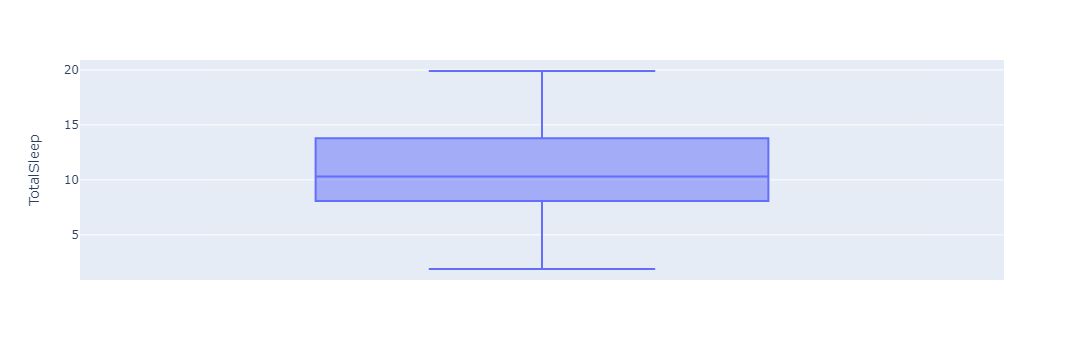

In [26]:
# Lets overlook the TotalSleep variable
px.box(df, orientation = "v", y = "TotalSleep")

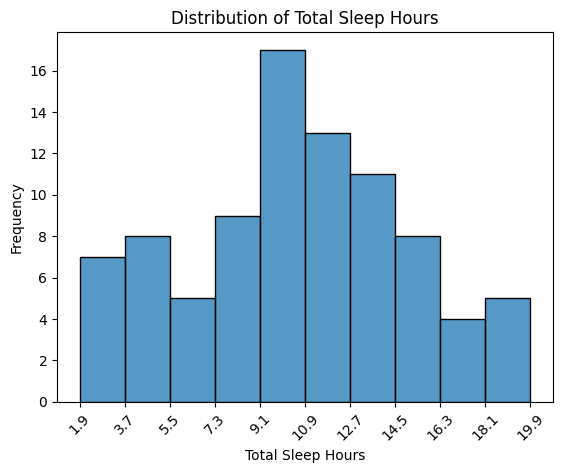

In [27]:
# Plot the histogram
sns.histplot(data=df, x='TotalSleep', bins=10, kde=False)
plt.xlabel('Total Sleep Hours')
plt.ylabel('Frequency')
plt.title('Distribution of Total Sleep Hours')

# Manually calculate bin edges
bin_edges = np.histogram_bin_edges(df['TotalSleep'], bins=10)

# Set the tick positions to the bin edges
plt.xticks(bin_edges, rotation=45)

plt.show()

In [28]:
sleep_mask = (df['TotalSleep'] >= 9.1) & (df['TotalSleep'] <= 10.9)

# Apply the mask to filter the DataFrame
df_filtered_sleep = df[sleep_mask]

#Let's check if there is a trend regarding the vore
print("Herbi:")
print(sum(df_filtered_sleep["herbi"]))
print("Carni:")
print(sum(df_filtered_sleep["carni"]))
print("Omni:")
print(sum(df_filtered_sleep["omni"]))
print("Insecti:")
sum(df_filtered_sleep["insecti"])

Herbi:
2
Carni:
3
Omni:
11
Insecti:


2

In [29]:
df_filtered_sleep["Order"].value_counts()

Order
Primates          8
Carnivora         3
Erinaceomorpha    2
Rodentia          2
Soricomorpha      2
Artiodactyla      1
Name: count, dtype: int64

 • There is disparities in the Total Sleep. As per the histogram, the distribution approaches a normal one. We have checked above the attributes "vore" and "order" for the median values (between 9.1 and 10.9 of sleep). Most of the observations in the median are omni(vore) and/or belong to the primates order.

## Conservation

The conservation status of a group of organisms (for instance, a species) indicates whether the group still exists and how likely the group is to become extinct in the near future ( source: https://en.wikipedia.org/wiki/Conservation_status)

In [30]:
# Lets look at the Conservation column (holds 29 nan or null values)
df.Conservation.value_counts()

Conservation
lc              30
domesticated    10
vu               7
en               4
nt               4
cd               2
cr               1
Name: count, dtype: int64

•  Most of the observations with a value belong to lower risk categories:  Domesticated, nt (Near Threatened), cd (
Conservation Dependent), lc (least concerned)). Total observations in this category:46 

•In order to define whether the conservation status has some weight on TotalSleep and Dreaming attributes, t we would need to be able to compare between closely related animals with different conservati n.


In [31]:
# Let's encode the column and check if we should keep it
encoded_conserv_df = pd.get_dummies(df, columns=['Conservation'], dummy_na = True,dtype = int)
df_encoded_conserv = encoded_conserv_df.select_dtypes(include=['number'])

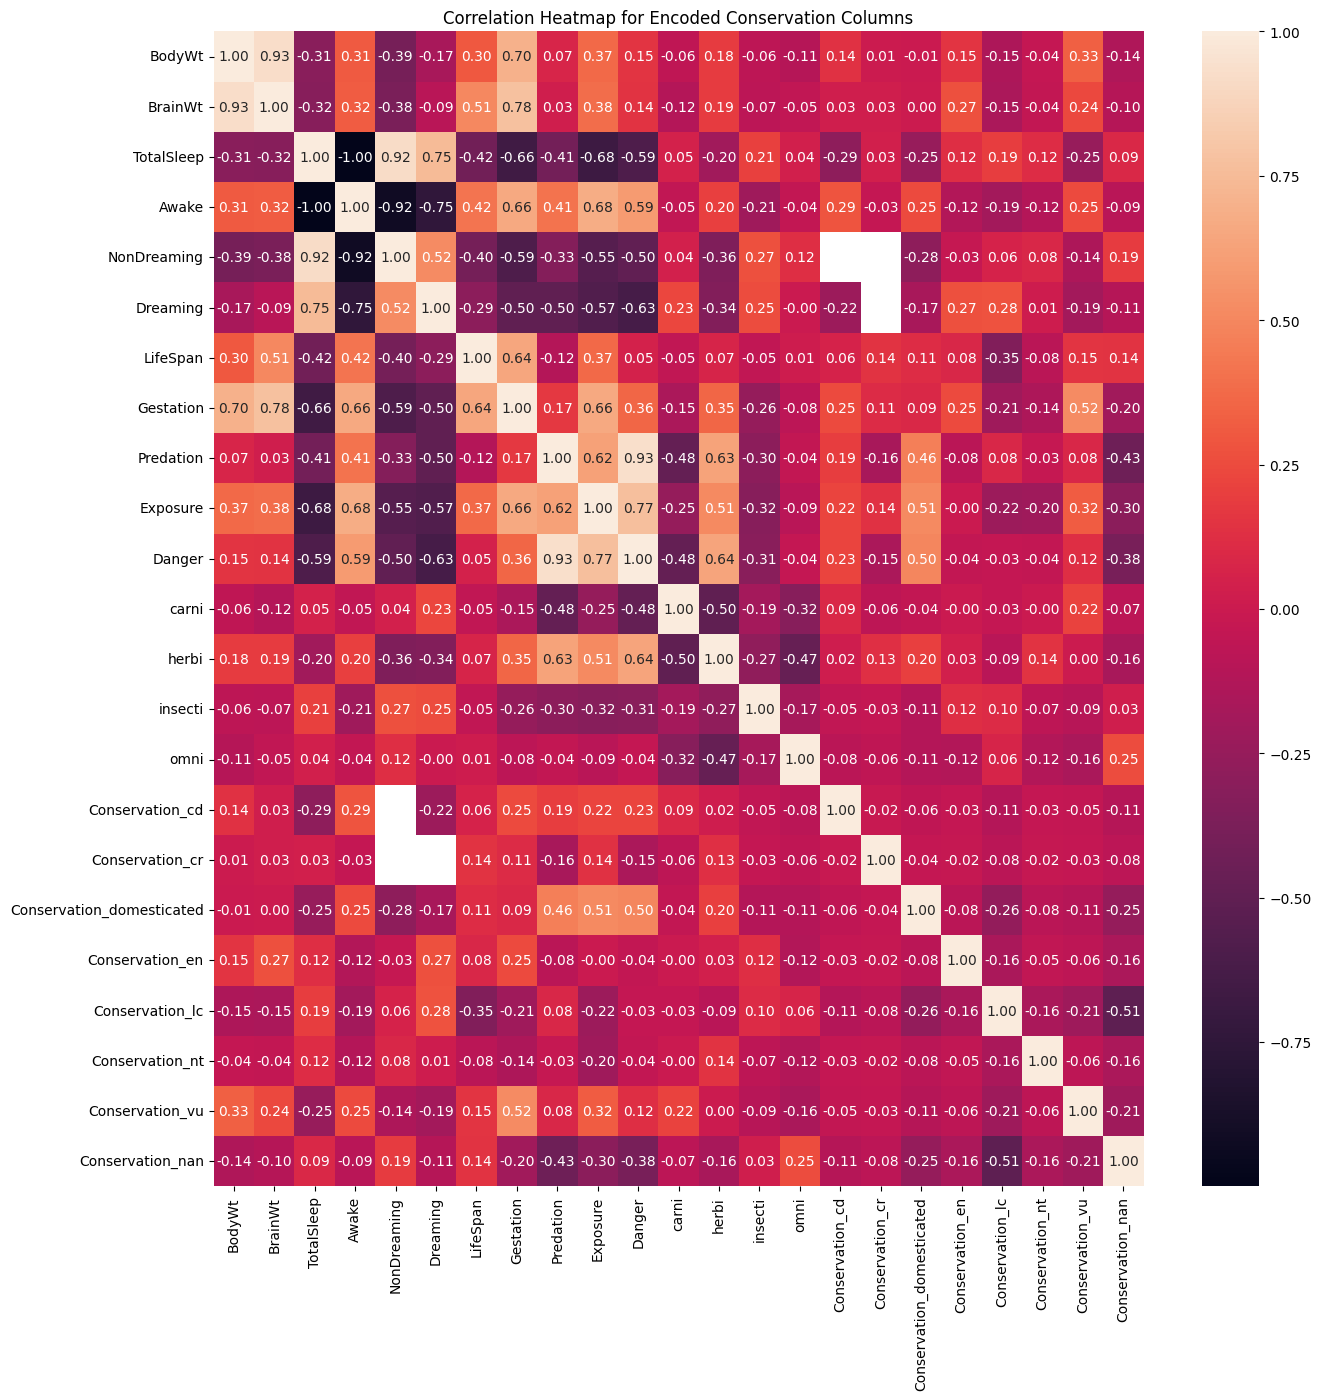

In [32]:
#Let's look at the heat map to check for correlation of "conservation" with other attributes
# Plot the heatmap for the correlation matrix
plt.figure(figsize=(15, 15))
                   
sns.heatmap(df_encoded_conserv.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap for Encoded Conservation Columns')
plt.show()


Correlation with TotalSleep and Dreaming is really low for all "conservation" values. We've tried nevertheless to fill up the null values to see if we can improve the correlation:

In [33]:
#First we filtered the null values
df[df['Conservation'].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
1,African giant pouched rat,Cricetomys,Rodentia,NaN,1.000,6.60,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.00,8.7,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,mouse
3,Arctic fox,Vulpes,Carnivora,NaN,3.380,44.50,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0,1,0,0,0,fox
6,Baboon,Papio,Primates,NaN,25.235,180.00,9.4,14.6,9.1,0.7,27.0,180.0,4.0,4.0,4.0,0,0,0,1,Baboon
8,Bottle-nosed dolphin,Tursiops,Cetacea,NaN,173.330,0.00,5.2,18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,dolphin
12,Chimpanzee,Pan,Primates,NaN,52.200,440.00,9.7,14.3,8.3,1.4,50.0,230.0,1.0,1.0,1.0,0,0,0,1,Chimpanzee
15,Cotton rat,Sigmodon,Rodentia,NaN,0.148,1.18,11.3,12.7,NaN,1.1,NaN,NaN,NaN,NaN,NaN,0,1,0,0,rat
17,Deer mouse,Peromyscus,Rodentia,NaN,0.021,0.00,11.5,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,mouse
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,0.00,15.8,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,chipmunk
26,Galago,Galago,Primates,NaN,0.200,5.00,9.8,14.2,9.5,1.2,10.4,120.0,2.0,2.0,2.0,0,0,0,1,Galago


In [34]:
#We tried to fill up the missing values using iucn redlist : https://www.iucnredlist.org
df.loc[[1,3,6,15,26,27,41], 'Conservation'] = 'lc'
df.loc[[8,49], 'Conservation'] = 'vu'
df.loc[[12,46,48], 'Conservation'] = 'en'
df.loc[[17], 'Conservation'] = 'nt'
#We stopped here as we couldn't find all the species

We could not fill the missing values properly because the species column is not precise enough to distinguish between different species with different conservation values in the iucn redlist. For example the Nancy Ma's night monkey is vu, the Spix's Night monkey is lc. 

We decided against keeping the column as we could not fill it up and it was not really relevant correlation wise. We will drop it together with the rest of columns we decide that are not worth keeping for building the model.

## Dreaming 

As we saw in the preliminary wrangling, "Dreaming" column has many missing values.

We can use the complementarity or coherence between attributes "Dreaming", "NonDreaming", "Awake" and "TotalSleep" to fill up some of the null values of these columns:

• Awake + Total Sleep = 24

• NonDreaming + Dreaming = Total Sleep

We decided to:
- replace the nulls by 0 for "NonDreaming" if "Dreaming" = "TotalSleep".
- replace the null values by 0 for "Dreaming" if the value of "NonDreaming" = "TotalSleep".
- fill the "NonDreaming" missing values with "TotalSleep"-"Dreaming"

In [35]:
for i, r in df.iterrows():
    if pd.isna(r['NonDreaming']):
        df.at[i, 'NonDreaming'] = r['TotalSleep'] - r['Dreaming']
    elif r['NonDreaming'] == r['TotalSleep']:
        df.at[i, 'Dreaming'] = 0

for i, r in df.iterrows():
    if r['NonDreaming'] == r['TotalSleep']:
        df.at[i, 'Dreaming'] = 0
#Finally lets check how many nan we have left in those columns
df.isna().sum() 

Species          0
Genus            0
Order            0
Conservation    16
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming     23
Dreaming        23
LifeSpan        33
Gestation       33
Predation       29
Exposure        29
Danger          29
carni            0
herbi            0
insecti          0
omni             0
Animal_Name      0
dtype: int64

## BrainWt

As seen in the preliminary wrangling, there were 23 0 values in the BrainWt column. As the literature backing this project states that BrainWt is an important variable in TotalSleep, we need to complete this column as much as possible.

In [36]:
#Let's print the BrainWt = 0 collumn
df_zerobrain = df[df["BrainWt"] == 0]
df_zerobrain.head(5)

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.0,8.7,15.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,mouse
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.330,0.0,5.2,18.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,dolphin
10,Caspian seal,Phoca,Carnivora,vu,86.000,0.0,3.5,20.50,3.1,0.4,NaN,NaN,NaN,NaN,NaN,1,0,0,0,seal
11,Cheetah,Acinonyx,Carnivora,lc,50.000,0.0,12.1,11.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,Cheetah
14,Common porpoise,Phocoena,Cetacea,vu,53.180,0.0,5.6,18.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,porpoise


• None of the data has been provided in the original article's dataset. It is not a loading issue. The data is missing.

• We've tried to check for similar species to the ones with 0 BrainWt values. For example: the caspian seal
df[(df['Order'] == 'Carnivora') | (df['Species'].str.contains('seal', case=False))]. Nevertheless the difference in size among members of the same species makes it too vague to guess anything.

• Our data set is not rich enough to tacle this BrainWt problem just with our data.

We checked the correlation between BodyWt and BrainWt:

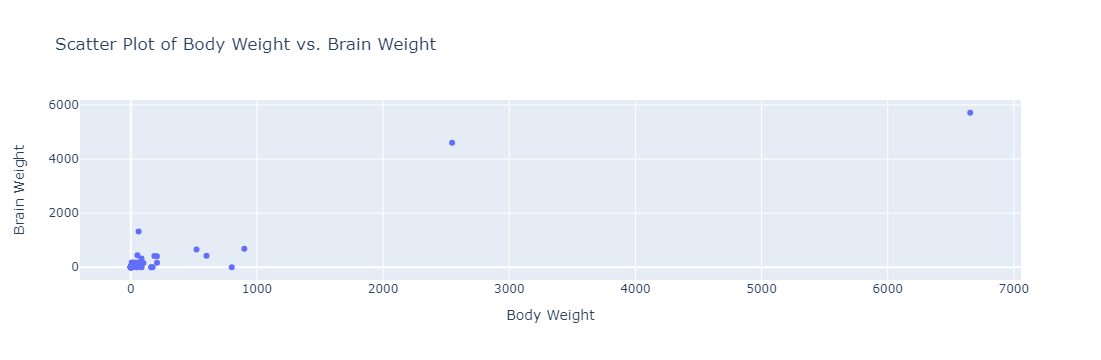

In [37]:
# Scatter plot of body weight vs. brain weight
fig = px.scatter(df, x='BodyWt', y='BrainWt', title='Scatter Plot of Body Weight vs. Brain Weight')
fig.update_layout(xaxis_title='Body Weight', yaxis_title='Brain Weight')
fig.show()

• In Size and Scaling in Primates (p.151) we found a table with minimum values of brain weight for several species. In the same table in (b), there's reference for a lot of articles.

• The following ressources contains many of the values we are looking for:     https://web.archive.org/web/20170705160118/https://kb.osu.edu/dspace/bitstream/handle/1811/3110/V40N05_219.pdf;jsessionid=6DB132604F156BFCA1C3094AF565BE38?sequence=1  (Ohio Journal of Science)
 
https://www.researchgate.net/profile/Dieter-Kruska/publication/266737971_Mammalian_Domestication_and_its_Effect_on_Brain_Structure_and_Behavior/links/543a3ed50cf24a6ddb95ec60/Mammalian-Domestication-and-its-Effect-on-Brain-Structure-and-Behavior.pdf (in the appendix)

https://www.biodiversitylibrary.org/partpdf/191127

https://sizegraf.com/blog/list-of-brain-weights-for-animals/  (The Ultimate List of Brain Weights for Animals (TULBWA))

In [38]:
df_zerobrain

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.0,8.7,15.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,mouse
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.330,0.0,5.2,18.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,dolphin
10,Caspian seal,Phoca,Carnivora,vu,86.000,0.0,3.5,20.50,3.1,0.4,NaN,NaN,NaN,NaN,NaN,1,0,0,0,seal
11,Cheetah,Acinonyx,Carnivora,lc,50.000,0.0,12.1,11.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,Cheetah
14,Common porpoise,Phocoena,Cetacea,vu,53.180,0.0,5.6,18.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,porpoise
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.0,11.5,12.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,mouse
18,Degu,Octodon,Rodentia,lc,0.210,0.0,7.7,16.30,6.8,0.9,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Degu
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,0.0,15.8,8.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,chipmunk
45,Lion,Panthera,Carnivora,vu,161.499,0.0,13.5,10.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,Lion
50,Mongolian gerbil,Meriones,Rodentia,lc,0.053,0.0,14.2,9.80,12.3,1.9,NaN,NaN,NaN,NaN,NaN,0,1,0,0,gerbil


We replaced the 0's by mostly the values found in:  
- the article Brain-Weight and Body-Weight of Mammals  http://dx.doi.org/10.1080/00221309.1937.9917959
- Ohio Journal
- Ultimate Brain weight list

In case of several values in the same source or in two different sources, we used the mean value:

In [39]:
##Replacing 0's by values found in the mentioned sources
df.loc[[8], ['BrainWt']] = (1886+1573)/2 #Dolphin
df.loc[[10], ['BrainWt']] = (251+255) # Caspian Seal
df.loc[[11], ['BrainWt']] = 111 # Cheetah
df.loc[[14], ['BrainWt']] = 460 #Porpoise
df.loc[[45], ['BrainWt']] = (163 + 229.2 + 258 + 260)/4 #Lion
df.loc[[51], ['BrainWt']] = 24 #Mongoose Lemur / 'Lemur Mongoz'
df.loc[[55], ['BrainWt']] = 442 #Northern fur Seal
df.loc[[61], ['BrainWt']] = (2458 + 2466)/2 #Pilot Whale
# df.loc[[62], ['BrainWt']] = No values for potoroo
df.loc[[63], ['BrainWt']] = (88.6 + 109 + 118)/3  # Potto//Monkey Night
df.loc[[76], ['BrainWt']] = (4.5+3.3+3.8+4.8) #Thick tailed opposum
df.loc[[78], ['BrainWt']] = (15 + 14 + 13 + 15 + 15.1 + 18 + 24.9 +16 )/8 #Sloth
df.loc[[79], ['BrainWt']] = (270 + 225 + 302)/3 #Tiger

• Doing this revealed issues with the Body Weight column, too (e.g. the northern seal is set at 20 kg whereas males can be up to 270 kg)

We could not find the brain weight value for the species potoroo. Therefore we calculated the mean of the brainweight for animals with a similar body weight.

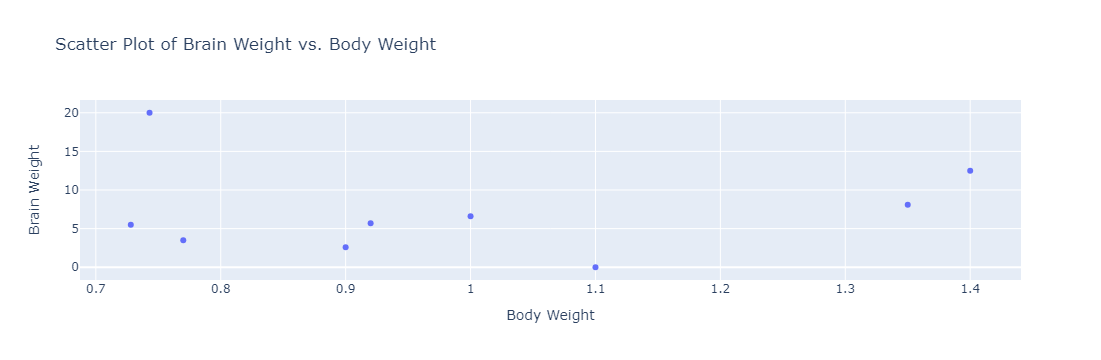

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.6,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.7,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0,0,1,0,0,squirrel
25,European hedgehog,Erinaceus,Erinaceomorpha,lc,0.770,3.5,10.1,13.9,6.6,4.1,6.0,42.0,2.0,2.0,2.0,0,0,0,1,hedgehog
38,Guinea pig,Cavis,Rodentia,domesticated,0.728,5.5,9.4,14.6,7.4,0.8,7.6,68.0,5.0,3.0,4.0,0,1,0,0,pig
52,Mountain beaver,Aplodontia,Rodentia,nt,1.350,8.1,14.4,9.6,8.4,2.8,NaN,45.0,3.0,1.0,3.0,0,1,0,0,beaver
62,Potoroo,Potorous,Diprotodontia,NaN,1.100,0.0,11.1,12.9,9.6,1.5,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Potoroo
72,Slow loris,Nyctibeus,Primates,NaN,1.400,12.5,11.0,13.0,NaN,NaN,12.7,90.0,2.0,2.0,2.0,1,0,0,0,loris
73,Squirrel monkey,Saimiri,Primates,NaN,0.743,20.0,9.6,14.4,8.2,1.4,NaN,NaN,NaN,NaN,NaN,0,0,0,1,monkey
75,Tenrec,Tenrec,Afrosoricida,NaN,0.900,2.6,15.6,8.4,11.0,2.3,4.5,60.0,2.0,1.0,2.0,0,0,0,1,Tenrec


In [40]:
# Filtered rows where BodyWt is in the range [0.6, 1.6]
filtered_df = df[(df['BodyWt'] >= 0.6) & (df['BodyWt'] <= 1.6)]

# Removed the row of the outlier (the potto)
max_brainwt_index = filtered_df['BrainWt'].idxmax()
filtered_df = filtered_df.drop(max_brainwt_index)


# Create a scatter plot using plotly express
fig = px.scatter(filtered_df, x='BodyWt', y='BrainWt', 
                 title='Scatter Plot of Brain Weight vs. Body Weight',
                 labels={'BodyWt': 'Body Weight', 'BrainWt': 'Brain Weight'})

fig.show()

filtered_df


In [41]:
# Calculate the mean of the 'BrainWt' column in filtered_df
mean_value = filtered_df['BrainWt'].mean()

# Display the calculated mean value
print("Mean value of 'BrainWt' column in filtered_df:", mean_value)

#Attribute the mean value to the  Potoroo
df.loc[62, 'BrainWt'] = mean_value

Mean value of 'BrainWt' column in filtered_df: 7.166666666666667


We double check that we have assigned the mean BrainWt value to the potoroo species:

In [42]:
df.loc[62]

Species               Potoroo
Genus                Potorous
Order           Diprotodontia
Conservation              NaN
BodyWt                    1.1
BrainWt              7.166667
TotalSleep               11.1
Awake                    12.9
NonDreaming               9.6
Dreaming                  1.5
LifeSpan                  NaN
Gestation                 NaN
Predation                 NaN
Exposure                  NaN
Danger                    NaN
carni                       0
herbi                       1
insecti                     0
omni                        0
Animal_Name           Potoroo
Name: 62, dtype: object

## Order

In this column, rodentia is by far the largest group. We checked if there are many missing values in the group:

In [43]:

df[df['Order'] == "Rodentia"].isna().sum() 

Species          0
Genus            0
Order            0
Conservation     5
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming      9
Dreaming         9
LifeSpan        15
Gestation       12
Predation       12
Exposure        12
Danger          12
carni            0
herbi            0
insecti          0
omni             0
Animal_Name      0
dtype: int64

We had a look to all the rows for which the order value is "rodentia"

In [44]:
df[df['Order'] == "Rodentia"]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.60,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.00,8.7,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,mouse
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.70,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0,0,1,0,0,squirrel
13,Chinchilla,Chinchilla,Rodentia,domesticated,0.420,6.40,12.5,11.5,11.0,1.5,7.0,112.0,5.0,4.0,4.0,0,1,0,0,Chinchilla
15,Cotton rat,Sigmodon,Rodentia,lc,0.148,1.18,11.3,12.7,10.2,1.1,NaN,NaN,NaN,NaN,NaN,0,1,0,0,rat
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.00,11.5,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,mouse
18,Degu,Octodon,Rodentia,lc,0.210,0.00,7.7,16.3,6.8,0.9,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Degu
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,0.00,15.8,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,chipmunk
31,Golden hamster,Mesocricetus,Rodentia,en,0.120,1.00,14.3,9.7,11.0,3.4,3.9,16.0,3.0,1.0,2.0,0,1,0,0,hamster
32,Golden-mantled ground squirrel,Spermophilus,Rodentia,lc,0.205,4.00,15.9,8.1,10.4,3.4,9.0,28.0,5.0,1.0,3.0,0,1,0,0,squirrel


In [45]:
df[df['Order'] == "Rodentia"].describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
count,22.000000,22.000000,22.000000,22.000000,13.000000,13.000000,7.000000,10.000000,10.000000,10.000000,10.000000,22.000000,22.000000,22.000000,22.000000
mean,0.288227,2.171818,12.468182,11.531818,9.607692,2.115385,5.700000,40.600000,3.800000,1.600000,2.900000,0.045455,0.818182,0.045455,0.090909
std,0.371329,2.727836,2.813299,2.813299,1.960213,0.960769,2.164871,29.515344,1.135292,1.074968,0.875595,0.213201,0.394771,0.213201,0.294245
min,0.021000,0.000000,7.000000,7.400000,6.300000,0.800000,3.200000,16.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.047000,0.000000,10.775000,9.525000,8.200000,1.300000,4.200000,22.000000,3.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000
50%,0.121000,0.700000,12.900000,11.100000,10.400000,2.000000,4.700000,29.000000,3.500000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000
75%,0.306500,4.000000,14.475000,13.225000,11.000000,2.800000,7.300000,44.250000,5.000000,1.750000,3.000000,0.000000,1.000000,0.000000,0.000000
max,1.350000,8.100000,16.600000,17.000000,12.300000,3.400000,9.000000,112.000000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000



• There should be a strong correlation between BrainWt and BodyWt (see source: Brain Size Scaling and Body Composition in Mammals
P. Thomas Schoenemann, Department of Anthropology, University of Pennsylvania, Philadelphia, Pa., USA), DOI: 10.1159/000073759)

• So let's infer the missing values from other rodents closely related in mass.

• Let's first do some plots to overview the available data

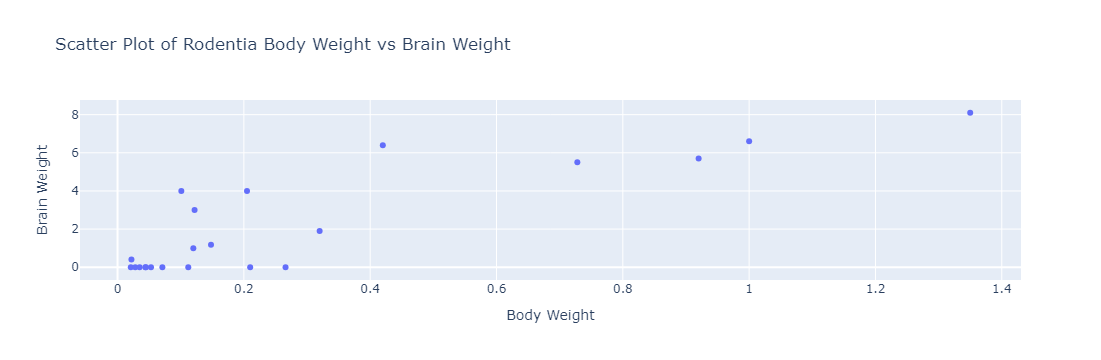

In [46]:
# Filter the DataFrame for Rodentias
rodentia_df = df[df['Order'] == "Rodentia"]

# Create a scatter plot using Plotly Express
fig = px.scatter(rodentia_df, x='BodyWt', y='BrainWt', title='Scatter Plot of Rodentia Body Weight vs Brain Weight', 
                 labels={'BodyWt': 'Body Weight', 'BrainWt': 'Brain Weight'})

# Show the plot
fig.show()



Let's also look at the rows directly to see if we have small rodentia data:

In [47]:
# Filter the DataFrame for Rodentia and non-zero values of BodyWt and BrainWt
rodentia_nonzero_df = df[(df['Order'] == "Rodentia") & (df['BodyWt'] != 0) & (df['BrainWt'] != 0)]

# Find the row with the smallest values for BodyWt and BrainWt
smallest_rodent = rodentia_nonzero_df.loc[(rodentia_nonzero_df['BodyWt'] + rodentia_nonzero_df['BrainWt']).idxmin()]

print("Rodentia with the smallest BodyWt and BrainWt:")
print(smallest_rodent)


Rodentia with the smallest BodyWt and BrainWt:
Species         House mouse
Genus                   Mus
Order              Rodentia
Conservation             nt
BodyWt                0.022
BrainWt                 0.4
TotalSleep             12.5
Awake                  11.5
NonDreaming            11.9
Dreaming                1.3
LifeSpan                3.2
Gestation              19.0
Predation               4.0
Exposure                1.0
Danger                  3.0
carni                     0
herbi                     1
insecti                   0
omni                      0
Animal_Name           mouse
Name: 40, dtype: object


Now, let's replace BrainWt = 0 values with the Brain Wt of the closest rodentia in BodyWt:

In [48]:
# Find rodentias with BrainWt == 0
rodentia_zero_brain = df.loc[(df['Order'] == 'Rodentia') & (df['BrainWt'] == 0)]

for index, row in rodentia_zero_brain.iterrows():
    # Find the rodentia with the closest BodyWt and non-zero BrainWt
    #First line locs the top rodentia with a minimum diff value in bodyweight with the
    #Selected one
    closest_rodent = df.loc[(df['BodyWt'] - row['BodyWt']).abs().argsort()]
    closest_rodent = closest_rodent[(closest_rodent['BrainWt'] != 0) & (closest_rodent.index != index)].iloc[0]
    
    # Update BrainWt with the value from the closest rodent
    df.at[index, 'BrainWt'] = closest_rodent['BrainWt']

# Print the updated DataFrame
df[df['Order'] == "Rodentia"]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.60,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,mouse
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.70,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0,0,1,0,0,squirrel
13,Chinchilla,Chinchilla,Rodentia,domesticated,0.420,6.40,12.5,11.5,11.0,1.5,7.0,112.0,5.0,4.0,4.0,0,1,0,0,Chinchilla
15,Cotton rat,Sigmodon,Rodentia,lc,0.148,1.18,11.3,12.7,10.2,1.1,NaN,NaN,NaN,NaN,NaN,0,1,0,0,rat
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.40,11.5,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,mouse
18,Degu,Octodon,Rodentia,lc,0.210,4.00,7.7,16.3,6.8,0.9,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Degu
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,1.00,15.8,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,chipmunk
31,Golden hamster,Mesocricetus,Rodentia,en,0.120,1.00,14.3,9.7,11.0,3.4,3.9,16.0,3.0,1.0,2.0,0,1,0,0,hamster
32,Golden-mantled ground squirrel,Spermophilus,Rodentia,lc,0.205,4.00,15.9,8.1,10.4,3.4,9.0,28.0,5.0,1.0,3.0,0,1,0,0,squirrel


• We're done with the brain's weights ! We filled up all the 0 values with the BrainWt of the closes rodent in BodyWt

#### Remarks about the rest of columns  

• Gestation is probably easier to fill with a good source than by using our small dataset. This also makes us think that we don't distinguish female and male. This is important because gestation should impact females more than male's danger column. 

• From the 1976 article provided we read that for large animals, exposure is high. Danger is independent of size. Carnivore and Omnivore have lower Predation. We also note that those data come from field observations hence we need to drop the idea of finding them in the litterature.

## Gestation Column

• The Gestation is most likely linked to LifeSpan and BodyWeight (the larger, the longer to devl), see "Evolution of Reproductive Life History in Mammals and the Associated Change of Functional Constraints", doi: 10.3390/genes12050740

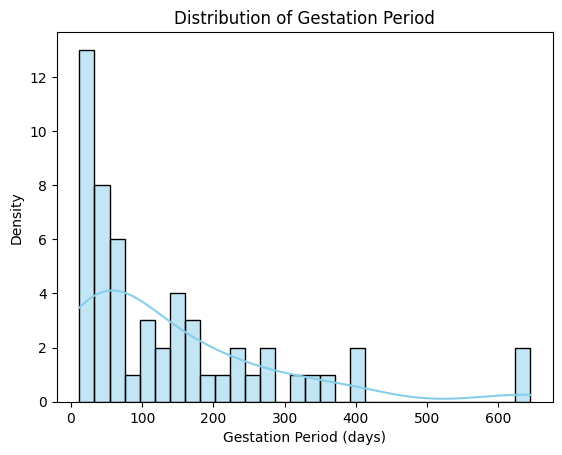

In [49]:
sns.histplot(df['Gestation'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Gestation Period')
plt.xlabel('Gestation Period (days)')
plt.ylabel('Density')

plt.show()

The distribution is extremely skewed to the right. Most of the observations (with values) belong to short gestations.

Now let's check the null values of the variable:

In [50]:
df[df["Gestation"].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.330000,8.7,15.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,mouse
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.330,1729.500000,5.2,18.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,dolphin
10,Caspian seal,Phoca,Carnivora,vu,86.000,506.000000,3.5,20.50,3.1,0.4,NaN,NaN,NaN,NaN,NaN,1,0,0,0,seal
11,Cheetah,Acinonyx,Carnivora,lc,50.000,111.000000,12.1,11.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,Cheetah
14,Common porpoise,Phocoena,Cetacea,vu,53.180,460.000000,5.6,18.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,porpoise
15,Cotton rat,Sigmodon,Rodentia,lc,0.148,1.180000,11.3,12.70,10.2,1.1,NaN,NaN,NaN,NaN,NaN,0,1,0,0,rat
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.400000,11.5,12.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,mouse
18,Degu,Octodon,Rodentia,lc,0.210,4.000000,7.7,16.30,6.8,0.9,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Degu
19,Desert hedgehog,Paraechinus,Erinaceomorpha,lc,0.550,2.400000,10.3,13.70,7.6,2.7,NaN,NaN,2.0,1.0,2.0,0,0,1,0,hedgehog
20,Dog,Canis,Carnivora,domesticated,14.000,70.000000,10.1,13.90,7.2,2.9,NaN,NaN,NaN,NaN,NaN,1,0,0,0,Dog


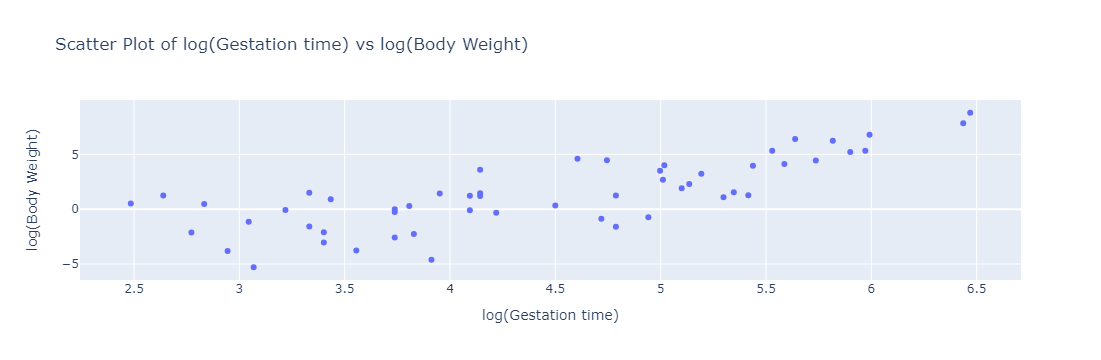

In [51]:
###We could use a Linear regression to get the Gestation values
#Lets check for corolation with other features


# Create a scatter plot Gestation vs. Body Weight
# The log makes for a better visualisation
fig = px.scatter(x=np.log(df['Gestation']), y=np.log(df['BodyWt']), 
                 title='Scatter Plot of log(Gestation time) vs log(Body Weight)',
                 labels={'x': 'log(Gestation time)', 'y': 'log(Body Weight)'})
fig.show()


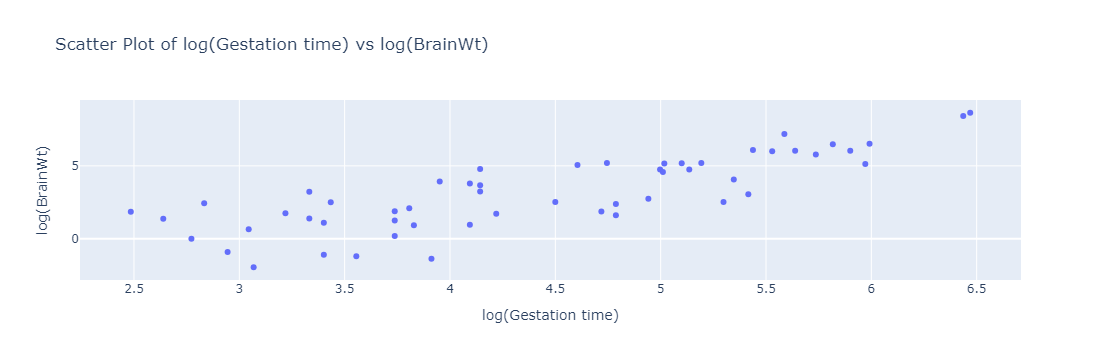

In [52]:

# Create a scatter Gestation vs. Brain Weight
fig = px.scatter(x=np.log(df['Gestation']), y=np.log(df['BrainWt']), 
                 title='Scatter Plot of log(Gestation time) vs log(BrainWt)',
                 labels={'x': 'log(Gestation time)', 'y': 'log(BrainWt)'})
fig.show()


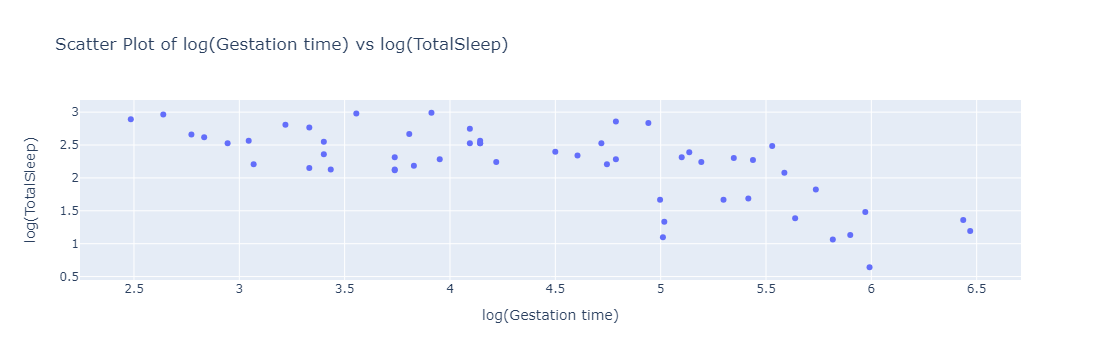

In [53]:
# Create a scatter Gestation vs. TotalSleep
fig = px.scatter(x=np.log(df['Gestation']), y=np.log(df['TotalSleep']), 
                 title='Scatter Plot of log(Gestation time) vs log(TotalSleep)',
                 labels={'x': 'log(Gestation time)', 'y': 'log(TotalSleep)'})
fig.show()



In [54]:
# We identify some linear behavior but it can be due to the large reduction of value coming from log as we don't see much if we don't use it.
# Lets use a regression model to infer the gestation Nans

save_df_gestation = df.groupby('Order')['Gestation'].describe()

# Drop rows with NaN values in 'Gestation' and prepare the data for training
df_train = df.dropna(subset=['Gestation'])
X_train = df_train[['BodyWt', 'BrainWt', 'TotalSleep']]  # Features (independent variables)
y_train = df_train['Gestation']  # Target variable

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict gestation time for the rows with NaN values
X_predict = df[df['Gestation'].isnull()][['BodyWt', 'BrainWt', 'TotalSleep']]  # Features for prediction
predicted_gestation = model.predict(X_predict)


# Replace NaN values in the 'Gestation' column with the predicted values
df.loc[df['Gestation'].isnull(), 'Gestation'] = predicted_gestation

# Now, evaluate the predictions

# Prepare the data for evaluation
X_test = df_train[['BodyWt', 'BrainWt', 'TotalSleep']]  # Features for evaluation
y_test = df_train['Gestation']  # True gestation values

# Predict gestation time using the trained model on the evaluation data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 4823.2790220428915
R-squared: 0.7652825963961023


In [55]:
#The MSE seems HUGE even though its large number in this column.
# Lets compare to previous df's stats on gestation
df.groupby('Order')['Gestation'].describe() - save_df_gestation
#Some weird values like 130 days of gestation for a mouse.

,count,mean,std,min,25%,50%,75%,max
Order,,,,,,,,
Afrosoricida,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
Artiodactyla,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Carnivora,7.0,18.697906,-13.246797,0.000000,1.500000,30.750078,72.091904,0.000000
Cetacea,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chiroptera,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cingulata,1.0,-52.403568,NaN,-104.807136,-78.605352,-52.403568,-26.201784,0.000000
Didelphimorphia,1.0,-6.891418,10.563889,-19.674255,-10.337128,-1.000000,-0.500000,0.000000
Diprotodontia,1.0,41.692737,NaN,0.000000,20.846368,41.692737,62.539105,83.385474
Erinaceomorpha,1.0,34.186742,NaN,0.000000,17.093371,34.186742,51.280113,68.373484


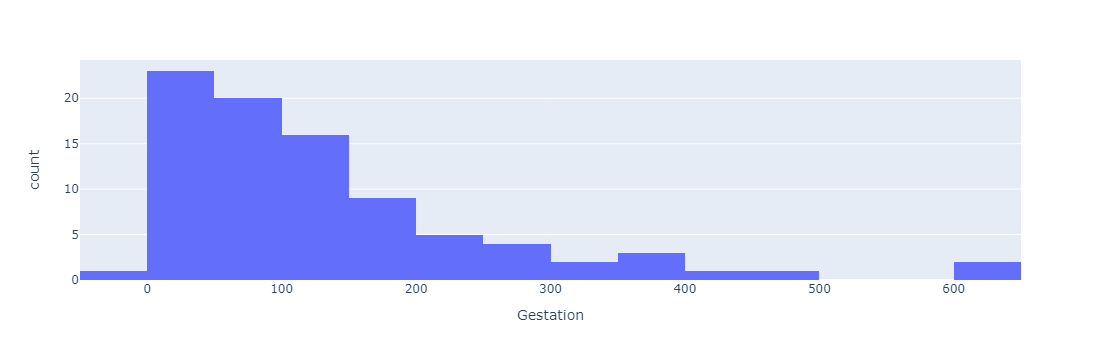

In [56]:
#Lets compare with the previous histo
px.histogram(data_frame=df, x="Gestation", nbins=30) 

In [57]:
#Some Means changed a lot which could imply that ouliers emerged.
# In any case if we have access to more data its better to use it.
# Lets fill the values with https://genomics.senescence.info/species
# With a larger dataset we would of kept and probably corrected some outliers. 5or remove outliers from the linear regression
# Here this decision is based on the small df and the importance of each row.

df.loc[[2], ["Gestation"]] = 25
df.loc[[8], ["Gestation"]] = 365
df.loc[[10], ["Gestation"]] = 330
df.loc[[11], ["Gestation"]] = 88
df.loc[[14], ["Gestation"]] = 320
df.loc[[15], ["Gestation"]] = 27
df.loc[[17], ["Gestation"]] = 24
df.loc[[18], ["Gestation"]] = 90
df.loc[[19], ["Gestation"]] = 37
df.loc[[20], ["Gestation"]] = 63
df.loc[[23], ["Gestation"]] = 30
df.loc[[27], ["Gestation"]] = 70
df.loc[[28], ["Gestation"]] = 122
df.loc[[34], ["Gestation"]] = 229
df.loc[[37], ["Gestation"]] = 17
df.loc[[45], ["Gestation"]] = 109
df.loc[[50], ["Gestation"]] = 25
df.loc[[51], ["Gestation"]] = 120
df.loc[[55], ["Gestation"]] = 240
df.loc[[56], ["Gestation"]] = 25
df.loc[[61], ["Gestation"]] = 452
df.loc[[62], ["Gestation"]] = 30
df.loc[[63], ["Gestation"]] = 170
df.loc[[69], ["Gestation"]] = 26
df.loc[[73], ["Gestation"]] = 161
df.loc[[74], ["Gestation"]] = 40
df.loc[[76], ["Gestation"]] = 14
df.loc[[77], ["Gestation"]] = 27
df.loc[[78], ["Gestation"]] = 141
df.loc[[79], ["Gestation"]] = 105
df.loc[[83], ["Gestation"]] = 25
df.loc[[84], ["Gestation"]] = 21
df.loc[[86], ["Gestation"]] = 30

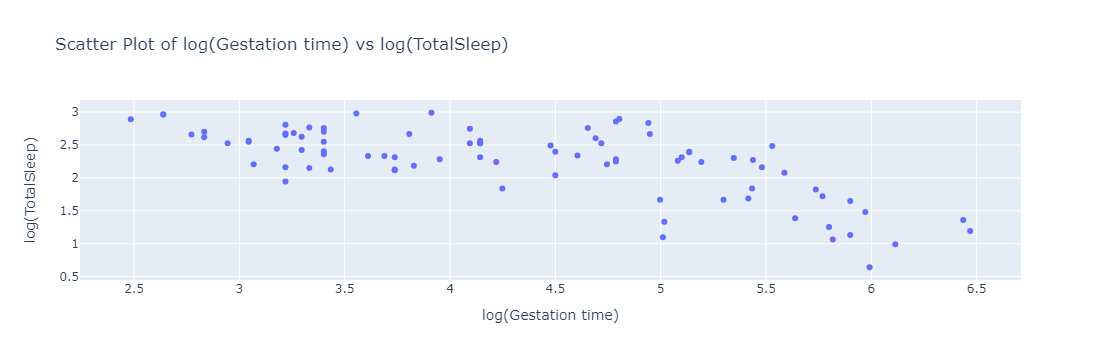

In [58]:
# Lets compare to previous scatter (looks very good)
fig = px.scatter(x=np.log(df['Gestation']), y=np.log(df['TotalSleep']), 
                 title='Scatter Plot of log(Gestation time) vs log(TotalSleep)',
                 labels={'x': 'log(Gestation time)', 'y': 'log(TotalSleep)'})
fig.show()

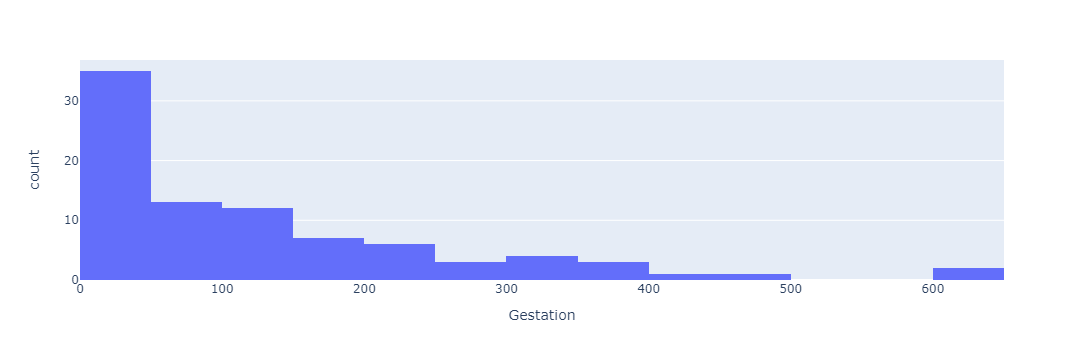

In [59]:
#Good too.
px.histogram(data_frame=df, x="Gestation", nbins=30) 

## Lifespan

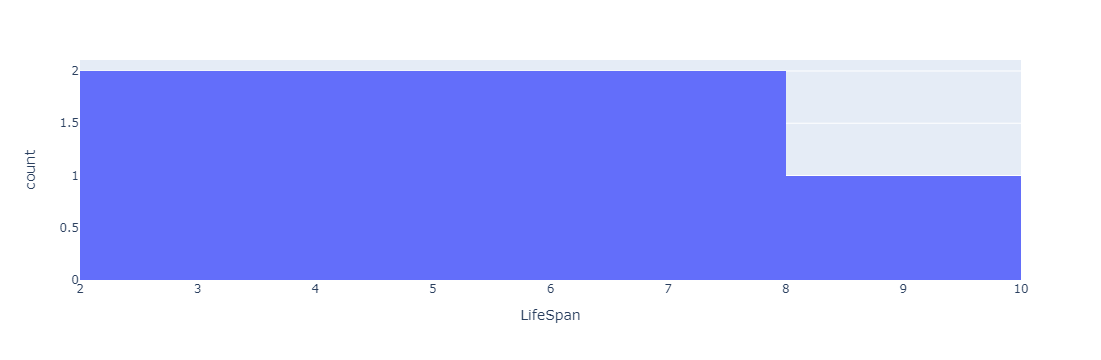

In [60]:
#Lets first look at lifespan for rodentias as we have many of them and they are quite similar and size and so on.

filtered_df = df[df['Order'] == "Rodentia"].dropna(subset=['LifeSpan'])
px.histogram(data_frame=filtered_df, x="LifeSpan", nbins=5)

• We notice a lot of similar values !

In [61]:
#Lets further investigate this lack of diversity
df[(df['Order'] == "Rodentia") & (~df['LifeSpan'].isna())]['LifeSpan'].value_counts() 
# code : ~ takes the negation of the following

LifeSpan
4.5    1
7.0    1
3.9    1
9.0    1
7.6    1
3.2    1
4.7    1
Name: count, dtype: int64

In [62]:
df.Genus.value_counts()
#With 80 different values, there is no interest in encoding it
#df = df.drop(["Genus"],axis=1) : AT THE END

Genus
Spermophilus    3
Panthera        3
Equus           2
Vulpes          2
Canis           2
               ..
Priodontes      1
Genetta         1
Galago          1
Erinaceus       1
Eutamias        1
Name: count, Length: 80, dtype: int64

• We only have 7 different values of the lifespan 

• while we have 22 rodentias...

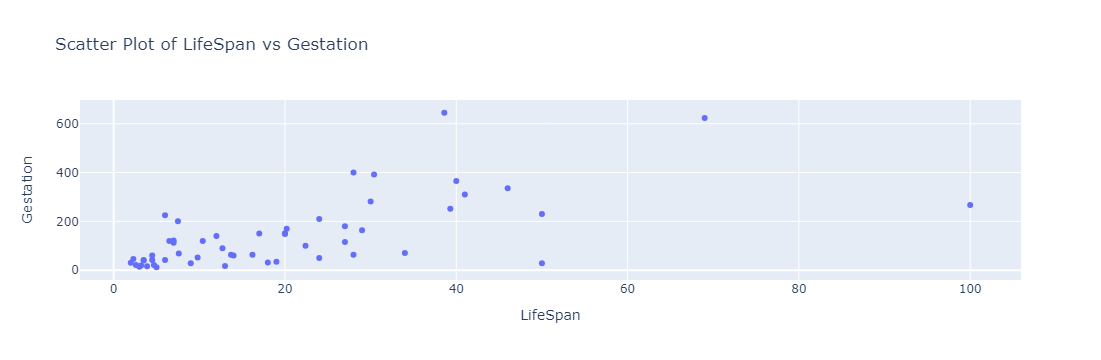

In [63]:
df.isna().sum()
# The longer the gestation, the longer the lifepsan.
# Lets look at a scatter plot of the two.

fig = px.scatter(df, x='LifeSpan', y='Gestation', title='Scatter Plot of LifeSpan vs Gestation')

fig.update_layout(
    title='Scatter Plot of LifeSpan vs Gestation',
    xaxis_title='LifeSpan',
    yaxis_title='Gestation'
)

fig.show()


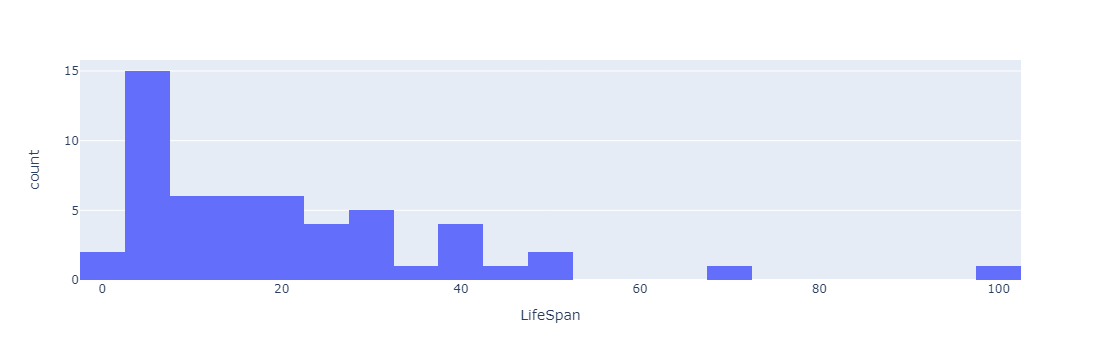

In [64]:
#Lets look at the LifeSpan's repartition
px.histogram(data_frame=df, x="LifeSpan", nbins=30)

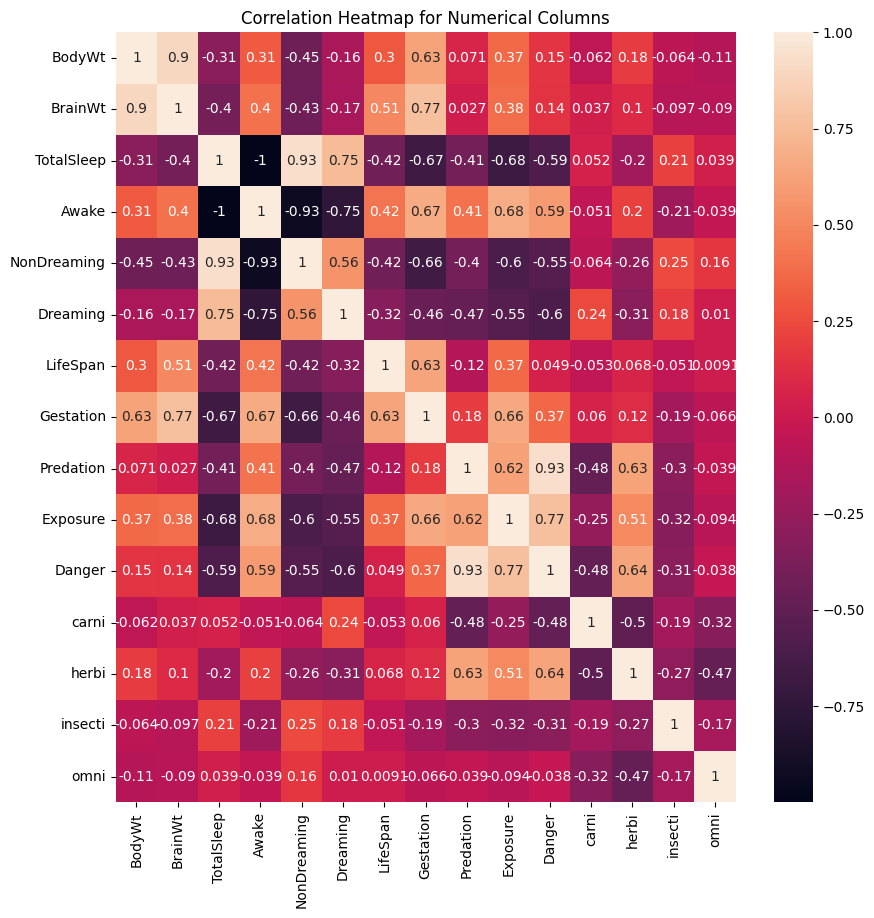

In [65]:
#Lets look at the heat map to check for correlation with other values
# Remove the first four columns and create a new DataFrame df_numerical
df_numerical = df.select_dtypes(include=['number'])
# Plot the heatmap for df_numerical with annotations in each cell
plt.figure(figsize=(10, 10))
sns.heatmap(df_numerical.corr(), annot=True)
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()


We try now with a general scatter plot for all the numerical values

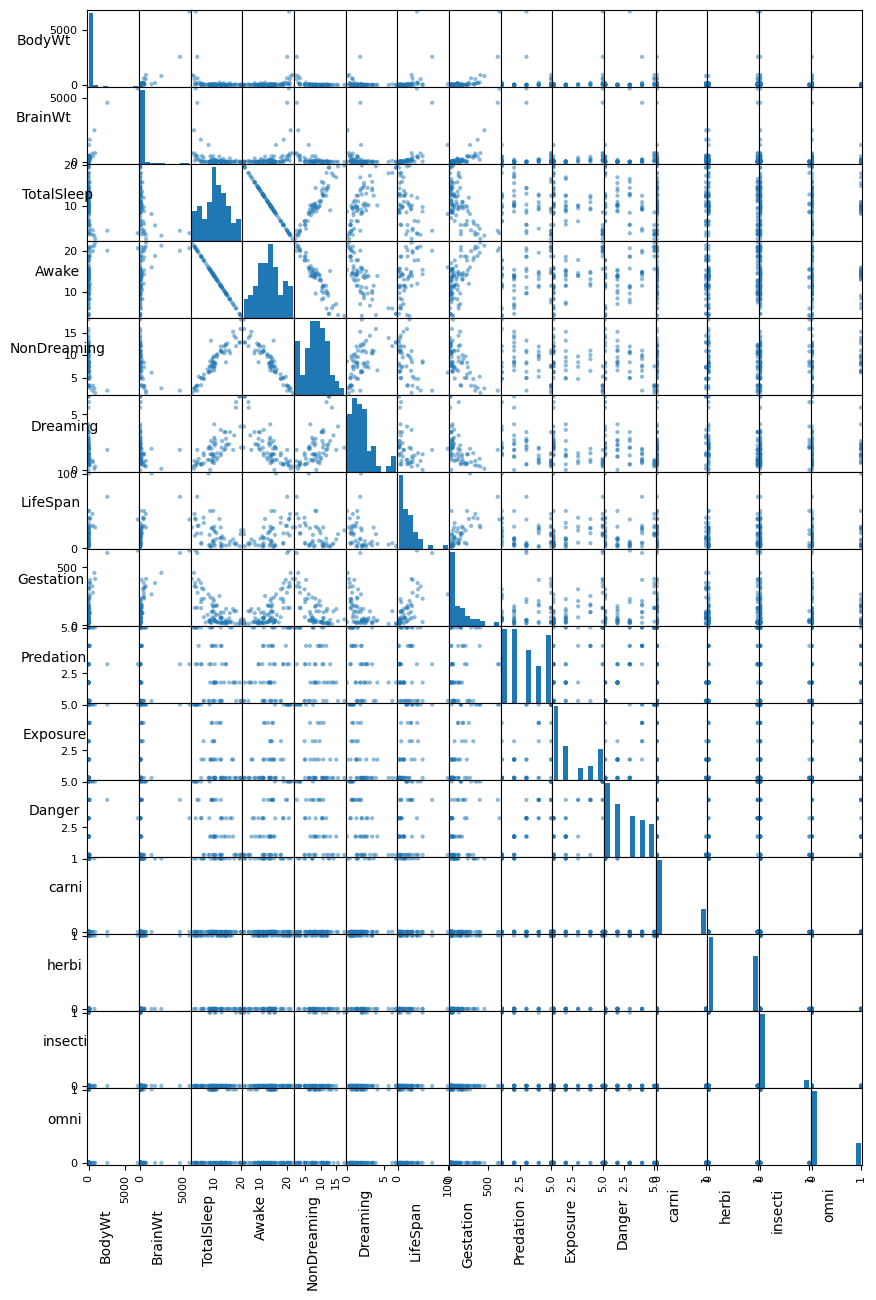

In [66]:
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(10, 15))

# Adjust the rotation of x-axis tick labels
for ax in scatter_matrix.ravel():
    ax.xaxis.label.set_rotation(90)
    ax.xaxis.label.set_horizontalalignment('right')
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_horizontalalignment('center')

# Show the plot
plt.show()

• Connected most to brain weight and gestation

• The most efficient and secure way to fill these is again to use real data as we have a small data set

In [67]:
#Lets count the number of nan in each order
df.groupby('Order')['LifeSpan'].apply(lambda x: x.isna().sum())

Order
Afrosoricida        0
Artiodactyla        0
Carnivora           6
Cetacea             3
Chiroptera          0
Cingulata           0
Didelphimorphia     1
Diprotodontia       1
Erinaceomorpha      1
Hyracoidea          1
Lagomorpha          0
Monotremata         0
Perissodactyla      0
Pilosa              1
Primates            3
Proboscidea         0
Rodentia           15
Scandentia          0
Soricomorpha        1
Name: LifeSpan, dtype: int64

• Most of the missing ones are in the rodentias which only contains 7 different values. Again, its better to look for new data.

In [68]:
#Lets first compare the values we find on the internet
# with the ones we have
df[(df['Order'] == 'Rodentia') & ~df['LifeSpan'].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.6,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat
13,Chinchilla,Chinchilla,Rodentia,domesticated,0.420,6.4,12.5,11.5,11.0,1.5,7.0,112.0,5.0,4.0,4.0,0,1,0,0,Chinchilla
31,Golden hamster,Mesocricetus,Rodentia,en,0.120,1.0,14.3,9.7,11.0,3.4,3.9,16.0,3.0,1.0,2.0,0,1,0,0,hamster
32,Golden-mantled ground squirrel,Spermophilus,Rodentia,lc,0.205,4.0,15.9,8.1,10.4,3.4,9.0,28.0,5.0,1.0,3.0,0,1,0,0,squirrel
38,Guinea pig,Cavis,Rodentia,domesticated,0.728,5.5,9.4,14.6,7.4,0.8,7.6,68.0,5.0,3.0,4.0,0,1,0,0,pig
40,House mouse,Mus,Rodentia,nt,0.022,0.4,12.5,11.5,11.9,1.3,3.2,19.0,4.0,1.0,3.0,0,1,0,0,mouse
43,Laboratory rat,Rattus,Rodentia,lc,0.320,1.9,13.0,11.0,10.6,2.6,4.7,21.0,3.0,1.0,3.0,0,1,0,0,rat


• The problem to fill the values is that the definition given doesn't represent what is easily found in the litterature (mean lifespan), we need to find a source that has the same definition (max lifespan).

• S.acher (1959,1974) found that life spans of mammalian species are directly related to brain weight

• In the end it has been fixed using the values on https://genomics.senescence.info/species which has a very good database with well referenced values and the same defition than our dataset. It contains the identical definition of LifeSpan variable, under a different variable name (Longevity).

In [69]:
df[['Species', 'Genus', 'Order', 'LifeSpan']]

,Species,Genus,Order,LifeSpan
0,African elephant,Loxodonta,Proboscidea,38.6
1,African giant pouched rat,Cricetomys,Rodentia,4.5
2,African striped mouse,Rhabdomys,Rodentia,NaN
3,Arctic fox,Vulpes,Carnivora,14.0
4,Arctic ground squirrel,Spermophilus,Rodentia,NaN
...,...,...,...,...
82,Vervet,Cercopithecus,Primates,24.0
83,Vesper mouse,Calomys,Rodentia,NaN
84,Vole,Microtus,Rodentia,NaN
85,Water opossum,Chironectes,Didelphimorphia,3.0


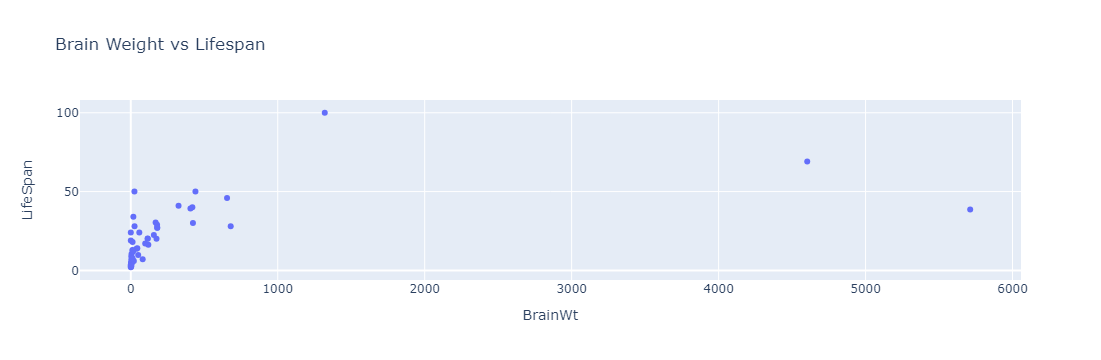

In [70]:
#Lets plot BrainWeight to lifespan as they might be corrolated.

fig = px.scatter(df, x='BrainWt', y='LifeSpan', 
                 title='Brain Weight vs Lifespan',
                 labels={'brainweight': 'Brain Weight (grams)', 'lifespan': 'Lifespan (years)'})

fig.show()
#No visual conclusion can be dranw. Lets fill it manually.

In [71]:
df[(df["Order"] == 'Rodentia') & (df['LifeSpan'].isna())]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,NaN,25.0,NaN,NaN,NaN,0,0,0,1,mouse
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.70,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0,0,1,0,0,squirrel
15,Cotton rat,Sigmodon,Rodentia,lc,0.148,1.18,11.3,12.7,10.2,1.1,NaN,27.0,NaN,NaN,NaN,0,1,0,0,rat
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.40,11.5,12.5,NaN,NaN,NaN,24.0,NaN,NaN,NaN,0,1,0,0,mouse
18,Degu,Octodon,Rodentia,lc,0.210,4.00,7.7,16.3,6.8,0.9,NaN,90.0,NaN,NaN,NaN,0,1,0,0,Degu
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,1.00,15.8,8.2,NaN,NaN,NaN,30.0,NaN,NaN,NaN,0,1,0,0,chipmunk
49,Mole rat,Spalax,Rodentia,vu,0.122,3.00,10.6,13.4,8.2,2.4,NaN,30.0,2.0,1.0,1.0,0,0,1,0,rat
50,Mongolian gerbil,Meriones,Rodentia,lc,0.053,0.33,14.2,9.8,12.3,1.9,NaN,25.0,NaN,NaN,NaN,0,1,0,0,gerbil
52,Mountain beaver,Aplodontia,Rodentia,nt,1.350,8.10,14.4,9.6,8.4,2.8,NaN,45.0,3.0,1.0,3.0,0,1,0,0,beaver
56,Northern grasshopper mouse,Onychomys,Rodentia,lc,0.028,0.30,14.5,9.5,NaN,NaN,NaN,25.0,NaN,NaN,NaN,1,0,0,0,mouse


In [72]:
df.loc[[2],"LifeSpan"] = 4.5
df.loc[[4],"LifeSpan"] = 7.1
df.loc[[15],"LifeSpan"] = 5.2
df.loc[[17],"LifeSpan"] = 8.3
df.loc[[18],"LifeSpan"] = 14
df.loc[[23],"LifeSpan"] = 10
df.loc[[49],"LifeSpan"] = 20.2
df.loc[[50],"LifeSpan"] = 6.3
df.loc[[52],"LifeSpan"] = 10
df.loc[[56],"LifeSpan"] = 4.5 #No Data for it, we took the same as the african mouse (its coherent to the other mouse on the website too) 
df.loc[[69],"LifeSpan"] = 10 #Assumption data on other Muskrats
df.loc[[77],"LifeSpan"] = 6.7
df.loc[[83],"LifeSpan"] = 4.5 #No Data for it, we took the same as the african mouse (its coherent to the other mouse on the website too) 
df.loc[[84],"LifeSpan"] = 4.8
df.loc[[86],"LifeSpan"] = 10
df.loc[[10],"LifeSpan"] = 50
df.loc[[11],"LifeSpan"] = 20.5
df.loc[[20],"LifeSpan"] = 15
df.loc[[45],"LifeSpan"] = 28
df.loc[[55],"LifeSpan"] = 25
df.loc[[79],"LifeSpan"] = 26.3
df.loc[[8],"LifeSpan"] = 51.6
df.loc[[14],"LifeSpan"] = 20.4
df.loc[[19],"LifeSpan"] = 6.3
df.loc[[34],"LifeSpan"] = 11.8
df.loc[[37],"LifeSpan"] = 2.2
df.loc[[51],"LifeSpan"] = 36.2
df.loc[[61],"LifeSpan"] = 63
df.loc[[62],"LifeSpan"] = 15
df.loc[[63],"LifeSpan"] = 32.4
df.loc[[73],"LifeSpan"] = 30.2
df.loc[[76],"LifeSpan"] = 2.9
df.loc[[78],"LifeSpan"] = 40

## Predation Exposure Danger (P.E.D.)

Let's remove columns that contain missing values and remove temporarily the rows with missing values:

In [73]:
df_temp = df.drop(["Awake", "LifeSpan", "NonDreaming"], axis=1)
df_temp = df_temp.dropna()
df_temp.describe()

,BodyWt,BrainWt,TotalSleep,Dreaming,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
count,43.000000,43.000000,43.000000,43.000000,43.00000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,127.274628,239.012093,10.111628,2.004651,139.50000,3.069767,2.441860,2.790698,0.116279,0.418605,0.162791,0.302326
std,418.046272,727.245736,4.851372,1.525022,136.41747,1.502305,1.637395,1.488978,0.324353,0.499169,0.373544,0.464701
min,0.005000,0.140000,1.900000,0.300000,12.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.262500,3.250000,6.250000,0.850000,36.00000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.950000,12.100000,9.800000,1.500000,112.00000,3.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,53.850000,177.000000,12.650000,2.650000,205.00000,4.500000,4.000000,4.000000,0.000000,1.000000,0.000000,1.000000
max,2547.000000,4603.000000,19.900000,6.600000,624.00000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
#Let's start by filling values for herbi
df_herbi = df[df['herbi'] == 1]

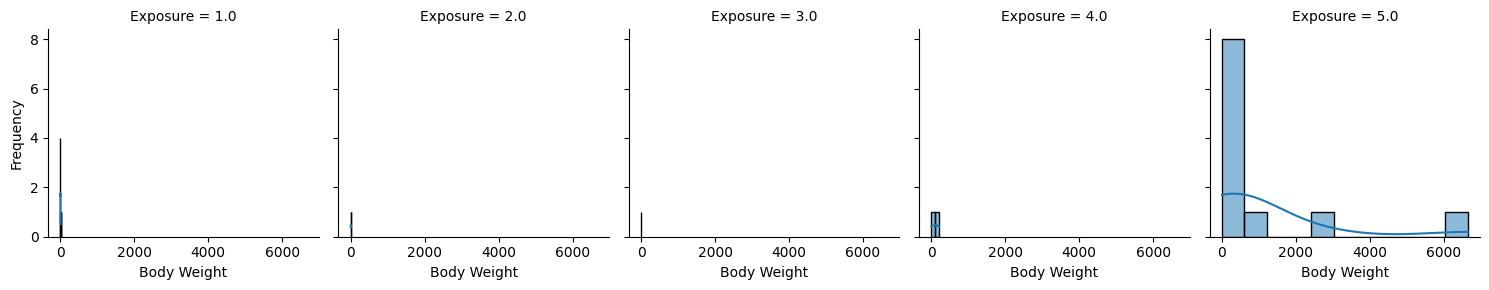

In [75]:
#Let's first look at the EXPOSURE
g = sns.FacetGrid(df_herbi, col="Exposure", margin_titles=True)
g.map_dataframe(sns.histplot, x="BodyWt", kde=True)
g.set_axis_labels("Body Weight", "Frequency")
plt.show()

In [76]:
#We notice a lot of small animals. Let's further investigate
percentage_over_10 = (df_herbi['BodyWt'] > 4).mean() * 100
print("Percentage of BodyWt values over 10:", percentage_over_10)

Percentage of BodyWt values over 10: 29.72972972972973


• only  30% of herbi's are over 4kg, And the NAN are exclusively for light
Mammals

In [77]:
#Let's extract the light herbi
df_herbi_light = df_herbi[df_herbi['BodyWt'] < 4].copy()
df_herbi_light.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
count,26.000000,26.000000,26.000000,26.000000,19.000000,19.000000,26.000000,26.000000,12.000000,12.000000,12.000000,26.0,26.0,26.0,26.0
mean,0.963923,6.317372,11.780769,12.219231,9.247368,1.684211,10.761538,63.538462,3.833333,1.916667,3.166667,0.0,1.0,0.0,0.0
std,1.196607,6.654520,3.385855,3.385855,2.446623,1.011195,8.841632,66.480813,1.114641,1.378954,0.834847,0.0,0.0,0.0,0.0
min,0.021000,0.300000,5.300000,7.400000,4.900000,0.500000,3.200000,16.000000,2.000000,1.000000,2.000000,0.0,1.0,0.0,0.0
25%,0.103750,1.045000,9.425000,9.625000,7.450000,0.900000,6.075000,25.000000,3.000000,1.000000,3.000000,0.0,1.0,0.0,0.0
50%,0.293000,4.000000,12.650000,11.350000,10.200000,1.500000,7.950000,29.000000,3.500000,1.000000,3.000000,0.0,1.0,0.0,0.0
75%,1.552500,10.575000,14.375000,14.575000,11.000000,2.400000,11.350000,84.500000,5.000000,2.250000,3.250000,0.0,1.0,0.0,0.0
max,3.850000,24.000000,16.600000,18.700000,12.300000,3.400000,40.000000,229.000000,5.000000,5.000000,5.000000,0.0,1.0,0.0,0.0


In [78]:
#Let's overlook
df_herbi_light.loc[:, ["Species", "BodyWt","Gestation","Predation","Exposure","Danger"]] # let's check what we did

,Species,BodyWt,Gestation,Predation,Exposure,Danger
4,Arctic ground squirrel,0.920,25.0,5.0,2.0,3.0
13,Chinchilla,0.420,112.0,5.0,4.0,4.0
15,Cotton rat,0.148,27.0,NaN,NaN,NaN
17,Deer mouse,0.021,24.0,NaN,NaN,NaN
18,Degu,0.210,90.0,NaN,NaN,NaN
23,Eastern american chipmunk,0.112,30.0,NaN,NaN,NaN
31,Golden hamster,0.120,16.0,3.0,1.0,2.0
32,Golden-mantled ground squirrel,0.205,28.0,5.0,1.0,3.0
34,Gray hyrax,2.625,229.0,NaN,NaN,NaN
38,Guinea pig,0.728,68.0,5.0,3.0,4.0


• They're all quite similar. Let's take the upper mean integer value
and give it to each of the missing values.

In [79]:
# Calculate mean values for 'Exposure', 'Danger', and 'Predation' in df_herbi_light and round to the nearest integer
mean_values_rounded = df_herbi_light[['Exposure', 'Danger', 'Predation']].mean().round().astype(int)

# Filter rows in df where 'herbi' is 1 and 'BodyWt' is less than 4
rows_to_fill_index = (df['herbi'] == 1) & (df['BodyWt'] < 4)

# Fill NaN values in 'Exposure', 'Danger', and 'Predation' with rounded mean values from df_herbi_light
df.loc[rows_to_fill_index, ['Exposure', 'Danger', 'Predation']] = df.loc[rows_to_fill_index, ['Exposure', 'Danger', 'Predation']].fillna(mean_values_rounded)


In [80]:
#Lets check our result
df.loc[(df['herbi'] == 1)& (df['BodyWt'] < 4), ["Species", "BodyWt","Gestation","Predation","Exposure","Danger"]] 

,Species,BodyWt,Gestation,Predation,Exposure,Danger
4,Arctic ground squirrel,0.920,25.0,5.0,2.0,3.0
13,Chinchilla,0.420,112.0,5.0,4.0,4.0
15,Cotton rat,0.148,27.0,4.0,2.0,3.0
17,Deer mouse,0.021,24.0,4.0,2.0,3.0
18,Degu,0.210,90.0,4.0,2.0,3.0
23,Eastern american chipmunk,0.112,30.0,4.0,2.0,3.0
31,Golden hamster,0.120,16.0,3.0,1.0,2.0
32,Golden-mantled ground squirrel,0.205,28.0,5.0,1.0,3.0
34,Gray hyrax,2.625,229.0,4.0,2.0,3.0
38,Guinea pig,0.728,68.0,5.0,3.0,4.0


In [81]:
#The results look ok. Lets continue with the omni.

In [82]:
#Let's extract the omni
df_omni = df[df['omni'] == 1]
df_omni.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
count,20.000000,20.000000,20.000000,20.000000,18.000000,18.000000,20.000000,20.000000,16.000000,16.000000,16.000000,20.0,20.0,20.0,20.0
mean,12.718000,132.048000,10.925000,13.075000,9.461111,1.972222,19.865000,111.625000,2.750000,2.125000,2.500000,0.0,0.0,0.0,1.0
std,24.693811,300.222595,2.949019,2.949019,2.719243,1.217908,23.232832,80.030401,1.183216,1.147461,1.154701,0.0,0.0,0.0,0.0
min,0.005000,0.140000,8.000000,6.000000,6.100000,0.600000,2.200000,12.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.0
25%,0.176000,2.575000,9.100000,13.075000,7.800000,1.250000,4.500000,41.500000,2.000000,1.000000,2.000000,0.0,0.0,0.0,1.0
50%,0.950000,11.050000,9.900000,14.100000,8.750000,1.850000,11.200000,117.500000,2.500000,2.000000,2.000000,0.0,0.0,0.0,1.0
75%,7.600000,131.000000,10.925000,14.900000,10.750000,2.275000,27.500000,170.000000,4.000000,3.000000,4.000000,0.0,0.0,0.0,1.0
max,86.250000,1320.000000,18.000000,16.000000,15.200000,5.600000,100.000000,267.000000,5.000000,4.000000,4.000000,0.0,0.0,0.0,1.0


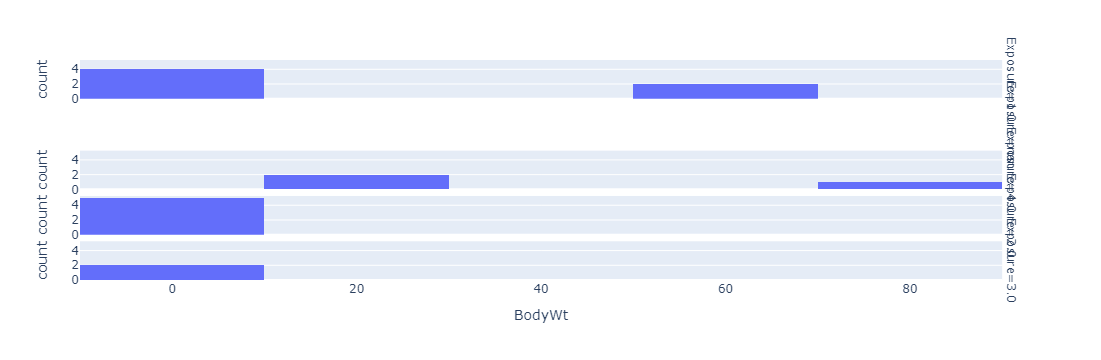

In [83]:
# Let's also investigate with a hist.
px.histogram(data_frame = df_omni, x = "BodyWt", facet_row = "Exposure") 

In [84]:
#Let's look at the missing values.
df_omni[df_omni['Exposure'].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,4.5,25.0,NaN,NaN,NaN,0,0,0,1,mouse
37,Greater short-tailed shrew,Blarina,Soricomorpha,lc,0.019,0.29,14.9,9.1,12.6,2.3,2.2,17.0,NaN,NaN,NaN,0,0,0,1,shrew
63,Potto,Perodicticus,Primates,lc,1.100,105.20,11.0,13.0,NaN,NaN,32.4,170.0,NaN,NaN,NaN,0,0,0,1,Potto
73,Squirrel monkey,Saimiri,Primates,NaN,0.743,20.00,9.6,14.4,8.2,1.4,30.2,161.0,NaN,NaN,NaN,0,0,0,1,monkey


• We are missing 2 primates, 1 rodentia, 1 Soricomorpha

• Let's look for similar rows in the df

In [85]:
df[(df['Order'] == 'Primates') & (df["BodyWt"]<5) & (df["omni"] == 1)] 

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
26,Galago,Galago,Primates,lc,0.200,5.0,9.8,14.2,9.5,1.2,10.4,120.0,2.0,2.0,2.0,0,0,0,1,Galago
57,Owl monkey,Aotus,Primates,NaN,0.480,15.5,17.0,7.0,15.2,1.8,12.0,140.0,2.0,2.0,2.0,0,0,0,1,monkey
63,Potto,Perodicticus,Primates,lc,1.100,105.2,11.0,13.0,NaN,NaN,32.4,170.0,NaN,NaN,NaN,0,0,0,1,Potto
73,Squirrel monkey,Saimiri,Primates,NaN,0.743,20.0,9.6,14.4,8.2,1.4,30.2,161.0,NaN,NaN,NaN,0,0,0,1,monkey
82,Vervet,Cercopithecus,Primates,lc,4.750,58.0,10.0,14.0,9.7,0.6,24.0,210.0,4.0,3.0,4.0,0,0,0,1,Vervet


• We have 3 very similar primates. Regarding Gestation, the Nan are closer to the first 2 which have 2 everywhere for P.E.D., so lets fill the missing values this way:

In [86]:
df.loc[[63, 73], ['Predation', 'Exposure', 'Danger']] = 2
df[(df['Order'] == 'Primates') & (df["BodyWt"]<5) & (df["omni"] == 1)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
26,Galago,Galago,Primates,lc,0.200,5.0,9.8,14.2,9.5,1.2,10.4,120.0,2.0,2.0,2.0,0,0,0,1,Galago
57,Owl monkey,Aotus,Primates,NaN,0.480,15.5,17.0,7.0,15.2,1.8,12.0,140.0,2.0,2.0,2.0,0,0,0,1,monkey
63,Potto,Perodicticus,Primates,lc,1.100,105.2,11.0,13.0,NaN,NaN,32.4,170.0,2.0,2.0,2.0,0,0,0,1,Potto
73,Squirrel monkey,Saimiri,Primates,NaN,0.743,20.0,9.6,14.4,8.2,1.4,30.2,161.0,2.0,2.0,2.0,0,0,0,1,monkey
82,Vervet,Cercopithecus,Primates,lc,4.750,58.0,10.0,14.0,9.7,0.6,24.0,210.0,4.0,3.0,4.0,0,0,0,1,Vervet


Let's now check at all the mouses in the df


In [87]:
df[df['Species'].str.contains('mouse', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,4.5,25.0,NaN,NaN,NaN,0,0,0,1,mouse
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.40,11.5,12.5,NaN,NaN,8.3,24.0,4.0,2.0,3.0,0,1,0,0,mouse
40,House mouse,Mus,Rodentia,nt,0.022,0.40,12.5,11.5,11.9,1.3,3.2,19.0,4.0,1.0,3.0,0,1,0,0,mouse
56,Northern grasshopper mouse,Onychomys,Rodentia,lc,0.028,0.30,14.5,9.5,NaN,NaN,4.5,25.0,NaN,NaN,NaN,1,0,0,0,mouse
83,Vesper mouse,Calomys,Rodentia,NaN,0.045,0.33,7.0,17.0,NaN,NaN,4.5,25.0,4.0,2.0,3.0,0,1,0,0,mouse


• For all of them Predation = 4, Danger = 3, Exposure = 1-2.

• The African Striped Mouse sleeps less : so exposure = 1.

•  The vore of the northern grasshopper probably doesn't impact
because they have same predators has the non-omni/carni ones.

In [88]:
df.loc[[2], ['Predation', 'Exposure', 'Danger']] = [4,1,3]
df.loc[[56], ['Predation', 'Exposure', 'Danger']] = [4,2,3]
df[df['Species'].str.contains('mouse', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,4.5,25.0,4.0,1.0,3.0,0,0,0,1,mouse
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.40,11.5,12.5,NaN,NaN,8.3,24.0,4.0,2.0,3.0,0,1,0,0,mouse
40,House mouse,Mus,Rodentia,nt,0.022,0.40,12.5,11.5,11.9,1.3,3.2,19.0,4.0,1.0,3.0,0,1,0,0,mouse
56,Northern grasshopper mouse,Onychomys,Rodentia,lc,0.028,0.30,14.5,9.5,NaN,NaN,4.5,25.0,4.0,2.0,3.0,1,0,0,0,mouse
83,Vesper mouse,Calomys,Rodentia,NaN,0.045,0.33,7.0,17.0,NaN,NaN,4.5,25.0,4.0,2.0,3.0,0,1,0,0,mouse


Let's look at the last one:

In [89]:
df[df['Order'].str.contains('Soricomorpha', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
24,Eastern american mole,Scalopus,Soricomorpha,lc,0.075,1.20,8.4,15.6,6.3,2.1,3.5,42.0,1.0,1.0,1.0,0,0,1,0,mole
37,Greater short-tailed shrew,Blarina,Soricomorpha,lc,0.019,0.29,14.9,9.1,12.6,2.3,2.2,17.0,NaN,NaN,NaN,0,0,0,1,shrew
44,Lesser short-tailed shrew,Cryptotis,Soricomorpha,lc,0.005,0.14,9.1,14.9,7.7,1.4,2.6,21.5,5.0,2.0,4.0,0,0,0,1,shrew
53,Musk shrew,Suncus,Soricomorpha,lc,0.048,0.33,12.8,11.2,10.8,2.0,2.0,30.0,4.0,1.0,3.0,0,0,1,0,shrew
74,Star-nosed mole,Condylura,Soricomorpha,lc,0.060,1.00,10.3,13.7,8.1,2.2,3.5,40.0,3.0,1.0,2.0,0,0,0,1,mole


• There is another short tailed shrew with similar features although it doesn't sleep as much (which increases exposure). Let's allocate 3 for exposure as for the other shrew and similar values for the two other features.

In [90]:
df.loc[[37], ['Predation', 'Exposure', 'Danger']] = [5,3,4]

Let's inspect the Carni now as the insecti don't miss any values

In [91]:
df_carni = df[df['carni'] == 1]
df_carni.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
count,22.000000,22.000000,22.000000,22.000000,11.000000,11.000000,22.000000,22.000000,12.000000,12.000000,12.000000,22.0,22.0,22.0,22.0
mean,80.381318,322.559848,11.004545,13.000000,7.990909,2.718182,23.113636,141.636364,1.583333,1.583333,1.333333,1.0,0.0,0.0,0.0
std,170.765900,606.250626,4.763700,4.770569,4.122731,2.205819,16.397598,129.548132,0.900337,0.668558,0.651339,0.0,0.0,0.0,0.0
min,0.028000,0.300000,2.700000,4.600000,2.600000,0.100000,2.900000,14.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0
25%,3.410000,19.525000,6.900000,10.625000,4.750000,1.350000,12.950000,63.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0
50%,17.245000,90.500000,11.550000,12.450000,7.300000,2.400000,20.450000,89.000000,1.000000,1.500000,1.000000,1.0,0.0,0.0,0.0
75%,85.750000,310.166667,13.375000,17.100000,11.850000,3.350000,28.000000,210.000000,2.000000,2.000000,1.250000,1.0,0.0,0.0,0.0
max,800.000000,2462.000000,19.400000,21.350000,14.300000,6.600000,63.000000,452.000000,4.000000,3.000000,3.000000,1.0,0.0,0.0,0.0


In [92]:
df_carni[df_carni['Exposure'].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.330,1729.500000,5.2,18.80,NaN,NaN,51.6,365.0,NaN,NaN,NaN,1,0,0,0,dolphin
10,Caspian seal,Phoca,Carnivora,vu,86.000,506.000000,3.5,20.50,3.1,0.4,50.0,330.0,NaN,NaN,NaN,1,0,0,0,seal
11,Cheetah,Acinonyx,Carnivora,lc,50.000,111.000000,12.1,11.90,NaN,NaN,20.5,88.0,NaN,NaN,NaN,1,0,0,0,Cheetah
14,Common porpoise,Phocoena,Cetacea,vu,53.180,460.000000,5.6,18.45,NaN,NaN,20.4,320.0,NaN,NaN,NaN,1,0,0,0,porpoise
20,Dog,Canis,Carnivora,domesticated,14.000,70.000000,10.1,13.90,7.2,2.9,15.0,63.0,NaN,NaN,NaN,1,0,0,0,Dog
45,Lion,Panthera,Carnivora,vu,161.499,227.550000,13.5,10.50,NaN,NaN,28.0,109.0,NaN,NaN,NaN,1,0,0,0,Lion
55,Northern fur seal,Callorhinus,Carnivora,vu,20.490,442.000000,8.7,15.30,7.3,1.4,25.0,240.0,NaN,NaN,NaN,1,0,0,0,seal
61,Pilot whale,Globicephalus,Cetacea,cd,800.000,2462.000000,2.7,21.35,2.6,0.1,63.0,452.0,NaN,NaN,NaN,1,0,0,0,whale
76,Thick-tailed opposum,Lutreolina,Didelphimorphia,lc,0.370,16.400000,19.4,4.60,12.8,6.6,2.9,14.0,NaN,NaN,NaN,1,0,0,0,opposum
79,Tiger,Panthera,Carnivora,en,162.564,265.666667,15.8,8.20,NaN,NaN,26.3,105.0,NaN,NaN,NaN,1,0,0,0,Tiger


• We have 6 Carnivora, 3 cetacea and 1 Didelphimorphia

In [93]:
df[df['Order'].str.contains('Carnivora', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
3,Arctic fox,Vulpes,Carnivora,lc,3.380,44.500000,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0,1,0,0,0,fox
10,Caspian seal,Phoca,Carnivora,vu,86.000,506.000000,3.5,20.5,3.1,0.4,50.0,330.0,NaN,NaN,NaN,1,0,0,0,seal
11,Cheetah,Acinonyx,Carnivora,lc,50.000,111.000000,12.1,11.9,NaN,NaN,20.5,88.0,NaN,NaN,NaN,1,0,0,0,Cheetah
20,Dog,Canis,Carnivora,domesticated,14.000,70.000000,10.1,13.9,7.2,2.9,15.0,63.0,NaN,NaN,NaN,1,0,0,0,Dog
21,Domestic cat,Felis,Carnivora,domesticated,3.300,25.600000,12.5,11.5,10.9,3.6,28.0,63.0,1.0,2.0,1.0,1,0,0,0,cat
27,Genet,Genetta,Carnivora,lc,2.000,17.500000,6.3,17.7,4.8,1.3,34.0,70.0,1.0,2.0,1.0,1,0,0,0,Genet
35,Gray seal,Haliochoerus,Carnivora,lc,85.000,325.000000,6.2,17.8,4.7,1.5,41.0,310.0,1.0,3.0,1.0,1,0,0,0,seal
36,Gray wolf,Canis,Carnivora,lc,36.330,119.500000,13.0,11.0,NaN,NaN,16.2,63.0,1.0,1.0,1.0,1,0,0,0,wolf
42,Jaguar,Panthera,Carnivora,nt,100.000,157.000000,10.4,13.6,NaN,NaN,22.4,100.0,1.0,1.0,1.0,1,0,0,0,Jaguar
45,Lion,Panthera,Carnivora,vu,161.499,227.550000,13.5,10.5,NaN,NaN,28.0,109.0,NaN,NaN,NaN,1,0,0,0,Lion


• They all basically have 1 for Predation, Danger, exposure

• Let's give 1 values to PED for all carnivoras

In [94]:
df.loc[(df['carni'] == 1) & (df['Order'] == "Carnivora") & (df['Exposure'].isna()), ['Predation', 'Exposure', 'Danger']] = 1

In [95]:
df[df['Order'].str.contains('Cetacea', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.33,1729.5,5.2,18.80,NaN,NaN,51.6,365.0,NaN,NaN,NaN,1,0,0,0,dolphin
14,Common porpoise,Phocoena,Cetacea,vu,53.18,460.0,5.6,18.45,NaN,NaN,20.4,320.0,NaN,NaN,NaN,1,0,0,0,porpoise
61,Pilot whale,Globicephalus,Cetacea,cd,800.00,2462.0,2.7,21.35,2.6,0.1,63.0,452.0,NaN,NaN,NaN,1,0,0,0,whale


• Dolphin are top ocean predators so lets have 1,1,1. Porpoise have predators, see : (https://www.sciencedirect.com/science/article/abs/pii/S1385110114002287) but they are still considered apex predators in a lot of different areas they live in so let's have 1,1,1. Pilot Whales are big, which could enduce exposure = 2, the rest is 1.

In [96]:
df.loc[[8], ['Predation', 'Exposure', 'Danger']] = [1,1,1]
df.loc[[14], ['Predation', 'Exposure', 'Danger']] = [1,1,1]
df.loc[[61], ['Predation', 'Exposure', 'Danger']] = [1,2,1]
df[df['Order'].str.contains('Cetacea', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.33,1729.5,5.2,18.80,NaN,NaN,51.6,365.0,1.0,1.0,1.0,1,0,0,0,dolphin
14,Common porpoise,Phocoena,Cetacea,vu,53.18,460.0,5.6,18.45,NaN,NaN,20.4,320.0,1.0,1.0,1.0,1,0,0,0,porpoise
61,Pilot whale,Globicephalus,Cetacea,cd,800.00,2462.0,2.7,21.35,2.6,0.1,63.0,452.0,1.0,2.0,1.0,1,0,0,0,whale


In [97]:
df[df['Order'].str.contains('Didelphimorphia', case=False)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
54,North American Opossum,Didelphis,Didelphimorphia,lc,1.70,6.3,18.0,6.0,13.8,5.6,5.0,12.0,2.0,1.0,1.0,0,0,0,1,Opossum
76,Thick-tailed opposum,Lutreolina,Didelphimorphia,lc,0.37,16.4,19.4,4.6,12.8,6.6,2.9,14.0,NaN,NaN,NaN,1,0,0,0,opposum
85,Water opossum,Chironectes,Didelphimorphia,lc,3.50,3.9,19.4,4.6,12.8,6.6,3.0,14.0,2.0,1.0,1.0,1,0,0,0,opossum


• The other 2 opposums have 2,1,1 so lets give the same values to our opposum.

In [98]:
df.loc[[76], ['Predation', 'Exposure', 'Danger']] = [2,1,1]

## Dreaming

• We provide extra care to this column. As it is one of the two target variable, we could decide not to touch it. Here, we decided to try and fill as many missing values as possible, to deepen our research and a fill them as uniformily as possible. Besides, our database does not have many rows to start with.

• Litterature, especially doi:10.1016/s0003-3472(05)81006-1  (Mark A. Elgar & al.) specify their values were incorrect... Some of them can be found in our dataset. Especially, the 2006 article specifically refers to the dataset and it states that it is compromised.

• We tried to look for the original source and add data from it so we fill up the values in a "coherent" way.

In [99]:
#Let's see which mammals we are missing and look for them in litterature:
df[df['Dreaming'].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name
0,African elephant,Loxodonta,Proboscidea,vu,6654.000,5712.000000,3.3,20.70,NaN,NaN,38.6,645.0,3.0,5.0,3.0,0,1,0,0,elephant
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.330000,8.7,15.30,NaN,NaN,4.5,25.0,4.0,1.0,3.0,0,0,0,1,mouse
3,Arctic fox,Vulpes,Carnivora,lc,3.380,44.500000,12.5,11.50,NaN,NaN,14.0,60.0,1.0,1.0,1.0,1,0,0,0,fox
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.700000,16.6,7.40,NaN,NaN,7.1,25.0,5.0,2.0,3.0,0,1,0,0,squirrel
8,Bottle-nosed dolphin,Tursiops,Cetacea,vu,173.330,1729.500000,5.2,18.80,NaN,NaN,51.6,365.0,1.0,1.0,1.0,1,0,0,0,dolphin
11,Cheetah,Acinonyx,Carnivora,lc,50.000,111.000000,12.1,11.90,NaN,NaN,20.5,88.0,1.0,1.0,1.0,1,0,0,0,Cheetah
14,Common porpoise,Phocoena,Cetacea,vu,53.180,460.000000,5.6,18.45,NaN,NaN,20.4,320.0,1.0,1.0,1.0,1,0,0,0,porpoise
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.400000,11.5,12.50,NaN,NaN,8.3,24.0,4.0,2.0,3.0,0,1,0,0,mouse
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,1.000000,15.8,8.20,NaN,NaN,10.0,30.0,4.0,2.0,3.0,0,1,0,0,chipmunk
33,Gorilla,Gorilla,Primates,cr,207.000,406.000000,12.0,12.00,NaN,NaN,39.3,252.0,1.0,4.0,1.0,0,1,0,0,Gorilla


Dreaming/TotalSleep ratio seems more appropriate for this analysis as it will take into account that mammals sleep different periods.
Let's add this column to a copy of our data set.

In [100]:
# We make a copy
df_div = df.copy()

# Add a new column with the result of "Dreaming" / "TotalSleep"
df_div['Ratio'] = df_div['Dreaming'] / df_div['TotalSleep']
df_div.head(5)

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,...,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
0,African elephant,Loxodonta,Proboscidea,vu,6654.000,5712.00,3.3,20.7,NaN,NaN,...,645.0,3.0,5.0,3.0,0,1,0,0,elephant,NaN
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.60,8.3,15.7,6.3,2.0,...,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat,0.240964
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,...,25.0,4.0,1.0,3.0,0,0,0,1,mouse,NaN
3,Arctic fox,Vulpes,Carnivora,lc,3.380,44.50,12.5,11.5,NaN,NaN,...,60.0,1.0,1.0,1.0,1,0,0,0,fox,NaN
4,Arctic ground squirrel,Spermophilus,Rodentia,lc,0.920,5.70,16.6,7.4,NaN,NaN,...,25.0,5.0,2.0,3.0,0,1,0,0,squirrel,NaN


Now let's check the importance of the Vores with regard to this ratio, as the genus is not enough in most cases.

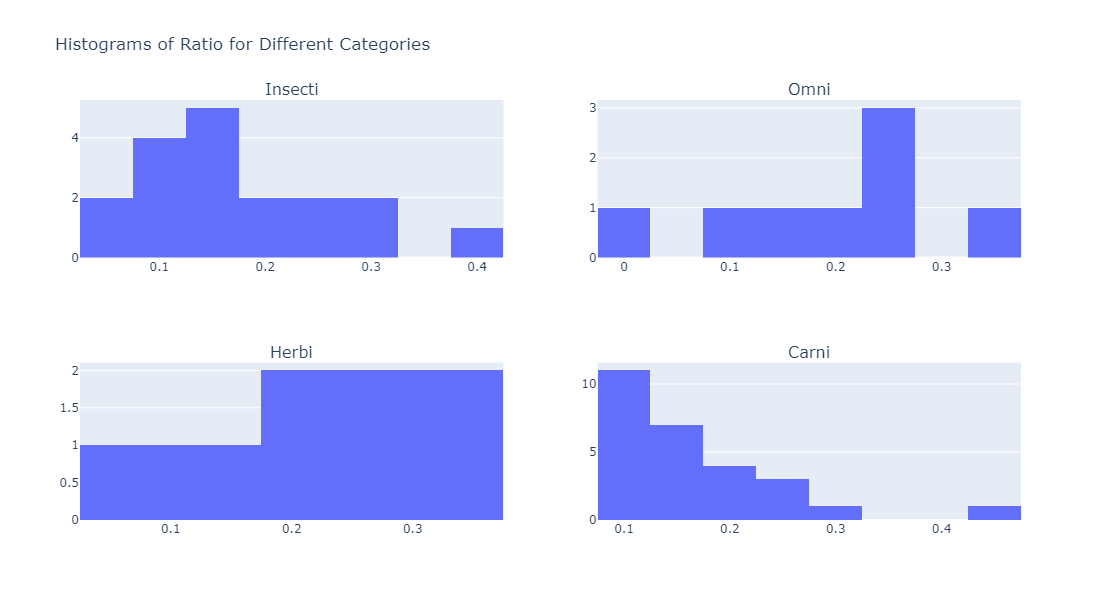

In [101]:
# Create a copy of the DataFrame containing only rows where 'carni' is equal to 1
df_div_inescti = df_div[df_div['insecti'] == 1].copy()
df_div_omni = df_div[df_div['omni'] == 1].copy()
df_div_herbi = df_div[df_div['herbi'] == 1].copy()
df_div_carni = df_div[df_div['carni'] == 1].copy()


from plotly.subplots import make_subplots

# Create histograms for each subset
histograms = []

for subset_df, category_name in [(df_div_inescti, 'Insecti'), 
                                  (df_div_omni, 'Omni'), 
                                  (df_div_herbi, 'Herbi'), 
                                  (df_div_carni, 'Carni')]:
    hist = px.histogram(data_frame=subset_df, x="Ratio", nbins=10, 
                        title=f'Histogram of Ratio for {category_name}')
    hist.update_xaxes(range=[0, 1])  # Set x-axis range
    histograms.append(hist)

# Create subplot figure
fig = make_subplots(rows=2, cols=2, subplot_titles=("Insecti", "Omni", "Herbi", "Carni"))

# Add each histogram to the subplot figure
for i, hist in enumerate(histograms, start=1):
    for trace in hist.data:
        fig.add_trace(trace, row=(i + 1) // 2, col=(i % 2) + 1)

# Update layout
fig.update_layout(height=600, width=800, title_text="Histograms of Ratio for Different Categories")

# Show plot
fig.show()


• We can fairly say that mammals show different tendencies depending on the "Vore". For example Carni and insecti dream less.

Let's check where are the missing values:

In [102]:
a = df_div_omni[df_div_omni['omni'] == 1]['Dreaming'].isna().sum()
b = df_div_inescti[df_div_inescti['insecti'] == 1]['Dreaming'].isna().sum()
c = df_div_herbi[df_div_herbi['herbi'] == 1]['Dreaming'].isna().sum()
d = df_div_carni[df_div_carni['carni'] == 1]['Dreaming'].isna().sum()

print("The # of Nan values for : \n omni is =", a, "\n insecti is =", b, "\n herbi is =", c, "\n carni is =", d)


The # of Nan values for : 
 omni is = 2 
 insecti is = 0 
 herbi is = 10 
 carni is = 11



• With regard to this : 

herbi      37 (10 missing)

carni      22 (11 missing)

omni       20 (2 missing)

insecti     8 (0 missing) : not necessary to study it.

Based on the heatmap the correlation between Dreaming and Danger (combinaison of exposure and predation) is stronger than the one with "Vore", "BrainWt" or "BodyWt". Same applies to Total Sleep

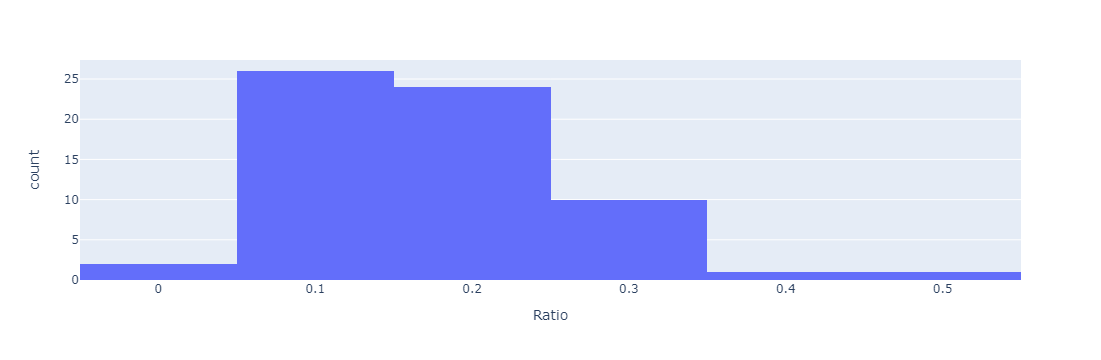

In [103]:
px.histogram(data_frame=df_div, x="Ratio", nbins=5)

In [104]:
#Let's start with omni.
df_div_omni

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,...,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.60,8.3,15.7,6.3,2.0,...,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat,0.240964
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,...,25.0,4.0,1.0,3.0,0,0,0,1,mouse,NaN
6,Baboon,Papio,Primates,lc,25.235,180.00,9.4,14.6,9.1,0.7,...,180.0,4.0,4.0,4.0,0,0,0,1,Baboon,0.074468
12,Chimpanzee,Pan,Primates,en,52.200,440.00,9.7,14.3,8.3,1.4,...,230.0,1.0,1.0,1.0,0,0,0,1,Chimpanzee,0.144330
25,European hedgehog,Erinaceus,Erinaceomorpha,lc,0.770,3.50,10.1,13.9,6.6,4.1,...,42.0,2.0,2.0,2.0,0,0,0,1,hedgehog,0.405941
26,Galago,Galago,Primates,lc,0.200,5.00,9.8,14.2,9.5,1.2,...,120.0,2.0,2.0,2.0,0,0,0,1,Galago,0.122449
37,Greater short-tailed shrew,Blarina,Soricomorpha,lc,0.019,0.29,14.9,9.1,12.6,2.3,...,17.0,5.0,3.0,4.0,0,0,0,1,shrew,0.154362
41,Human,Homo,Primates,lc,62.000,1320.00,8.0,16.0,6.1,1.9,...,267.0,1.0,1.0,1.0,0,0,0,1,Human,0.237500
44,Lesser short-tailed shrew,Cryptotis,Soricomorpha,lc,0.005,0.14,9.1,14.9,7.7,1.4,...,21.5,5.0,2.0,4.0,0,0,0,1,shrew,0.153846
48,Macaque,Macaca,Primates,en,6.800,179.00,10.1,13.9,8.4,1.2,...,164.0,2.0,3.0,2.0,0,0,0,1,Macaque,0.118812


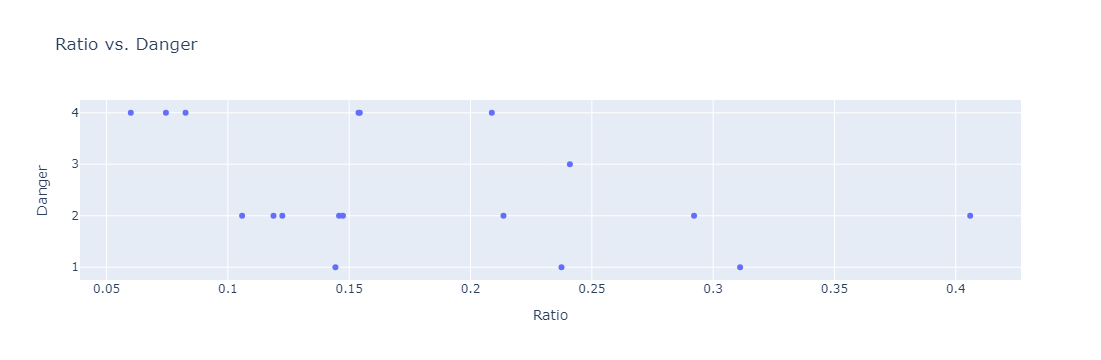

In [105]:
scatter_plot = px.scatter(df_div_omni, x='Ratio', y='Danger', title="Ratio vs. Danger")
scatter_plot.show()
#Wide anti-corrolation visible

In [106]:
df_div[(df_div['Order'] == 'Rodentia') & (df['omni'] == 1)]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,...,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
1,African giant pouched rat,Cricetomys,Rodentia,lc,1.000,6.60,8.3,15.7,6.3,2.0,...,42.0,3.0,1.0,3.0,0,0,0,1,pouched rat,0.240964
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,...,25.0,4.0,1.0,3.0,0,0,0,1,mouse,NaN


As for litterature, Dreaming is closely related to BrainWt too.

In [107]:
df_div[(df_div['BrainWt'] < 1)]


,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,...,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,...,25.0,4.0,1.0,3.0,0,0,0,1,mouse,NaN
7,Big brown bat,Eptesicus,Chiroptera,lc,0.023,0.30,19.7,4.3,15.8,3.9,...,35.0,1.0,1.0,1.0,0,0,1,0,bat,0.197970
17,Deer mouse,Peromyscus,Rodentia,nt,0.021,0.40,11.5,12.5,NaN,NaN,...,24.0,4.0,2.0,3.0,0,1,0,0,mouse,NaN
37,Greater short-tailed shrew,Blarina,Soricomorpha,lc,0.019,0.29,14.9,9.1,12.6,2.3,...,17.0,5.0,3.0,4.0,0,0,0,1,shrew,0.154362
40,House mouse,Mus,Rodentia,nt,0.022,0.40,12.5,11.5,11.9,1.3,...,19.0,4.0,1.0,3.0,0,1,0,0,mouse,0.104000
44,Lesser short-tailed shrew,Cryptotis,Soricomorpha,lc,0.005,0.14,9.1,14.9,7.7,1.4,...,21.5,5.0,2.0,4.0,0,0,0,1,shrew,0.153846
46,Little brown bat,Myotis,Chiroptera,en,0.010,0.25,19.9,4.1,17.9,2.0,...,50.0,1.0,1.0,1.0,0,0,1,0,bat,0.100503
50,Mongolian gerbil,Meriones,Rodentia,lc,0.053,0.33,14.2,9.8,12.3,1.9,...,25.0,4.0,2.0,3.0,0,1,0,0,gerbil,0.133803
53,Musk shrew,Suncus,Soricomorpha,lc,0.048,0.33,12.8,11.2,10.8,2.0,...,30.0,4.0,1.0,3.0,0,0,1,0,shrew,0.156250
56,Northern grasshopper mouse,Onychomys,Rodentia,lc,0.028,0.30,14.5,9.5,NaN,NaN,...,25.0,4.0,2.0,3.0,1,0,0,0,mouse,NaN


All ratios are between 0.1 and 0.2

In [108]:
df_div.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Ratio
count,87.000000,87.000000,87.000000,87.000000,64.000000,64.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,64.000000
mean,161.384310,269.772510,10.608046,13.393103,8.507812,1.948437,19.493103,127.798851,2.862069,2.137931,2.482759,0.252874,0.425287,0.091954,0.229885,0.180018
std,768.846727,842.571393,4.465793,4.467481,3.685506,1.483239,17.591408,134.613129,1.472006,1.356915,1.301717,0.437179,0.497253,0.290636,0.423198,0.090055
min,0.005000,0.140000,1.900000,4.100000,1.600000,0.000000,2.000000,12.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.202500,2.550000,8.150000,10.250000,6.250000,0.900000,6.300000,30.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.112500
50%,2.000000,15.500000,10.300000,13.700000,8.350000,1.650000,14.000000,68.000000,3.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.157072
75%,43.165000,163.000000,13.750000,15.850000,11.000000,2.450000,28.000000,170.000000,4.000000,2.000000,3.000000,0.500000,1.000000,0.000000,0.000000,0.238563
max,6654.000000,5712.000000,19.900000,22.100000,17.900000,6.600000,100.000000,645.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.461538


In [109]:
df_div[(df_div['BrainWt'] < 1) & (df_div['TotalSleep'] < 10.6) & (df_div['omni'] == 1)]
#These must be close, we can't add another layer or we won't have data anymore


,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,...,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
2,African striped mouse,Rhabdomys,Rodentia,NaN,0.044,0.33,8.7,15.3,NaN,NaN,...,25.0,4.0,1.0,3.0,0,0,0,1,mouse,NaN
44,Lesser short-tailed shrew,Cryptotis,Soricomorpha,lc,0.005,0.14,9.1,14.9,7.7,1.4,...,21.5,5.0,2.0,4.0,0,0,0,1,shrew,0.153846


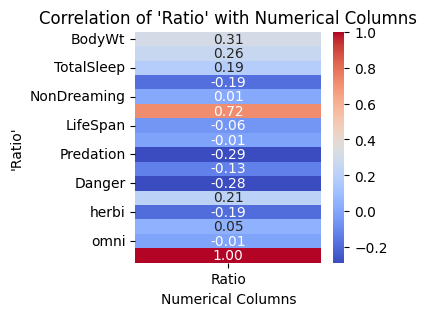

In [110]:
numerical_columns = df_div.select_dtypes(include=['number'])
correlation_matrix = numerical_columns.corr()
ratio_corr = correlation_matrix.loc['Ratio'] #Lets take only the ration as this is the key.


plt.figure(figsize=(3, 3))
sns.heatmap(ratio_corr.to_frame(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of 'Ratio' with Numerical Columns")
plt.xlabel("Numerical Columns")
plt.ylabel("'Ratio'")
plt.show()


• BodyWt, BrainWt, TotalSleep, Danger, (Carni or herbi : we have more data so we see correlation emerging which is not the case for the other generated vores)

In [111]:
#So that when we go above or under a value we know by how much.
selected_columns = ['BodyWt', 'BrainWt', 'TotalSleep','Danger','Ratio']
df_div[selected_columns].describe()

,BodyWt,BrainWt,TotalSleep,Danger,Ratio
count,87.000000,87.000000,87.000000,87.000000,64.000000
mean,161.384310,269.772510,10.608046,2.482759,0.180018
std,768.846727,842.571393,4.465793,1.301717,0.090055
min,0.005000,0.140000,1.900000,1.000000,0.000000
25%,0.202500,2.550000,8.150000,1.000000,0.112500
50%,2.000000,15.500000,10.300000,3.000000,0.157072
75%,43.165000,163.000000,13.750000,3.000000,0.238563
max,6654.000000,5712.000000,19.900000,5.000000,0.461538


In [112]:
df_div['Order'].value_counts()

Order
Rodentia           22
Carnivora          14
Primates           13
Artiodactyla        6
Soricomorpha        5
Hyracoidea          3
Cetacea             3
Perissodactyla      3
Didelphimorphia     3
Diprotodontia       2
Proboscidea         2
Cingulata           2
Erinaceomorpha      2
Chiroptera          2
Lagomorpha          1
Monotremata         1
Afrosoricida        1
Pilosa              1
Scandentia          1
Name: count, dtype: int64

In [113]:
df_div[df_div['Order'] == "Proboscidea"]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,...,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
0,African elephant,Loxodonta,Proboscidea,vu,6654.0,5712.0,3.3,20.7,NaN,NaN,...,645.0,3.0,5.0,3.0,0,1,0,0,elephant,NaN
5,Asian elephant,Elephas,Proboscidea,en,2547.0,4603.0,3.9,20.1,2.1,1.8,...,624.0,3.0,5.0,4.0,0,1,0,0,elephant,0.461538


• We might assume that when they share a name, two animals have a similar dreaming ratio (i.e. shrews in the Soricomorpha all have ~1.5, Opossum in the Didelphimorphia all have ~0.34,  Hyrax all have ~0.9) , monkey in primates (quite close), rat in rodentia (close)

• Careful : this is false for bats in Chiroptera (0.19 and 0.1), armadillos in Cingulata (0.33, 0.17), edgehogs in Erinaceomorpha (0.26 and 0.4)

In [114]:
#Lets do the above analysis more generally
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Adjust the width as needed

# Selecting only the desired columns
desired_columns = ['BodyWt', 'BrainWt', 'TotalSleep', 'Animal_Name', 'Ratio', 'Danger']
selected_df = df_div[desired_columns]

# Group by 'Animal_Name' and apply the reset_index function
grouped_df = selected_df.groupby('Animal_Name').apply(lambda x: x.reset_index(drop=True))

# Display the grouped DataFrame
print(grouped_df)

# Reset display options to default if needed
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')


                 BodyWt      BrainWt  TotalSleep  Animal_Name     Ratio  Danger
Animal_Name                                                                    
Baboon      0    25.235   180.000000         9.4       Baboon  0.074468     4.0
Cheetah     0    50.000   111.000000        12.1      Cheetah       NaN     1.0
Chimpanzee  0    52.200   440.000000         9.7   Chimpanzee  0.144330     1.0
Chinchilla  0     0.420     6.400000        12.5   Chinchilla  0.120000     4.0
Cow         0   600.000   423.000000         4.0          Cow  0.175000     5.0
Degu        0     0.210     4.000000         7.7         Degu  0.116883     3.0
Dog         0    14.000    70.000000        10.1          Dog  0.287129     1.0
Donkey      0   187.000   419.000000         3.1       Donkey  0.129032     5.0
Galago      0     0.200     5.000000         9.8       Galago  0.122449     2.0
Genet       0     2.000    17.500000         6.3        Genet  0.206349     1.0
Giraffe     0   899.995   680.000000    

C:\Users\Estitxu_Larralde\AppData\Local\Temp\ipykernel_25112\2997040516.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [115]:
#Our assumption Looks right apart from a few outliers (bats, seals, one rat...)
#Let's Implement this as a gausian around the mean. 


# Define a custom function to filter groups with at least one NaN value in the 'Ratio' column
def filter_nan_ratio(group):
    return group['Ratio'].isna().any() and group.duplicated(subset='Animal_Name').sum() >= 1 and not group['Ratio'].isna().all()

# Filter groups using the custom function
filtered_groups = grouped_df.groupby(level=0).filter(filter_nan_ratio)

# Display the filtered groups
print(filtered_groups)

                 BodyWt  BrainWt  TotalSleep Animal_Name     Ratio  Danger
Animal_Name                                                               
elephant    0  6654.000  5712.00         3.3    elephant       NaN     3.0
            1  2547.000  4603.00         3.9    elephant  0.461538     4.0
fox         0     3.380    44.50        12.5         fox       NaN     1.0
            1     4.230    50.40         9.8         fox  0.244898     1.0
mouse       0     0.044     0.33         8.7       mouse       NaN     3.0
            1     0.021     0.40        11.5       mouse       NaN     3.0
            2     0.022     0.40        12.5       mouse  0.104000     3.0
            3     0.028     0.30        14.5       mouse       NaN     3.0
            4     0.045     0.33         7.0       mouse       NaN     3.0
squirrel    0     0.920     5.70        16.6    squirrel       NaN     3.0
            1     0.205     4.00        15.9    squirrel  0.213836     3.0
            2     0.101  

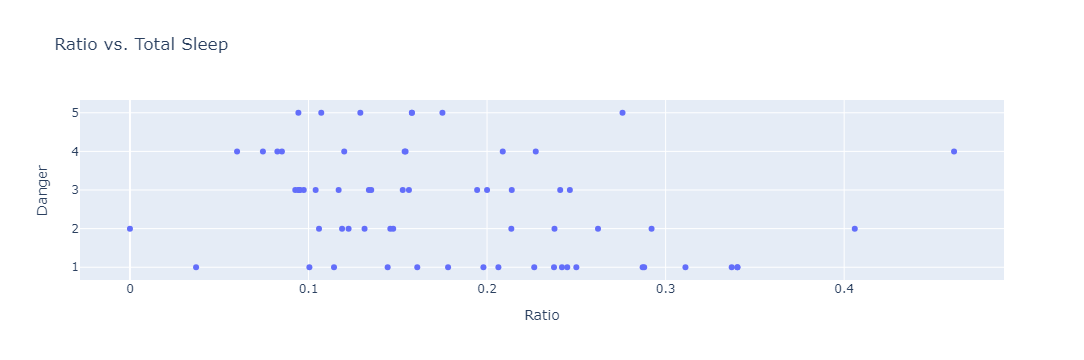

In [116]:

# We've looked at Danger, BrainWt, Total Sleep, BodyWT nothing links to a good help

# Drop rows with NaN values in 'Ratio' or 'Total Sleep' columns
df_div_cleaned = df_div.dropna(subset=['Ratio', 'TotalSleep'])

fig = px.scatter(df_div_cleaned, x='Ratio', y= "Danger", 
                 title='Ratio vs. Total Sleep', 
                 labels={'Total Sleep': 'Total Sleep', 'Ratio': 'Ratio'})
fig.show()

#We'll just put the mean values in the NaN of the Animal_name.

In [117]:
df_div['Ratio'] = df_div.groupby('Animal_Name')['Ratio'].transform(lambda x: x.fillna(x.mean()))


In [118]:
#It worked !

desired_columns = ['BodyWt', 'BrainWt', 'TotalSleep', 'Animal_Name', 'Ratio', 'Danger']
selected_df = df_div[desired_columns]

# Group by 'Animal_Name' and apply the reset_index function
grouped_df = selected_df.groupby('Animal_Name').apply(lambda x: x.reset_index(drop=True))
# Define a custom function to filter groups with at least one NaN value in the 'Ratio' column
def filter_nan_ratio(group):
    return group['Ratio'].isna().any() and group.duplicated(subset='Animal_Name').sum() >= 1

# Filter groups using the custom function
filtered_groups = grouped_df.groupby(level=0).filter(filter_nan_ratio)

# Display the filtered groups
print(filtered_groups)

               BodyWt  BrainWt  TotalSleep Animal_Name  Ratio  Danger
Animal_Name                                                          
chipmunk    0   0.112      1.0        15.8    chipmunk    NaN     3.0
            1   0.071      1.2        14.9    chipmunk    NaN     3.0


C:\Users\Estitxu_Larralde\AppData\Local\Temp\ipykernel_25112\2460441617.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Now lets look at the other Nan

In [119]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1200)  # Adjust the width as needed



# Selecting only the desired columns
desired_columns = ['BodyWt', 'BrainWt', 'Animal_Name', 'TotalSleep', 'Order', 'Ratio', 'Danger']
selected_df = df_div[desired_columns]

# Group by 'Order' and apply the reset_index function
grouped_df = selected_df.groupby('Order').apply(lambda x: x.reset_index(drop=True))

# Define a custom function to filter groups with at least one NaN value in the 'Ratio' column
def filter_nan_ratio(group):
    return group['Ratio'].isna().any()

# Filter groups using the custom function
filtered_groups = grouped_df.groupby(level=0).filter(filter_nan_ratio)

# Display the filtered groups
print(filtered_groups)


                  BodyWt      BrainWt  Animal_Name  TotalSleep         Order     Ratio  Danger
Order                                                                                         
Artiodactyla 0   600.000   423.000000          Cow         4.0  Artiodactyla  0.175000     5.0
             1   899.995   680.000000      Giraffe         1.9  Artiodactyla  0.157895     5.0
             2    33.500   115.000000         Goat         5.3  Artiodactyla  0.094340     5.0
             3    86.250   180.000000          Pig         9.1  Artiodactyla  0.208791     4.0
             4    14.800    98.200000         deer         3.0  Artiodactyla       NaN     5.0
             5    55.500   175.000000        Sheep         3.8  Artiodactyla  0.157895     5.0
Carnivora    0     3.380    44.500000          fox        12.5     Carnivora  0.244898     1.0
             1    86.000   506.000000         seal         3.5     Carnivora  0.114286     1.0
             2    50.000   111.000000      Cheetah

C:\Users\Estitxu_Larralde\AppData\Local\Temp\ipykernel_25112\2917484199.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



•  doi:10.1016/j.neubiorev.2008.05.023 and PMID: 19370995 suggests paradoxical sleep (hence dreaming) is non-existant in Cetaceans due to them sleeping with hald of the brain awake.

In [120]:
# Locate rows where 'Order' is 'Cetacea' and set the 'Ratio' column to 0
df_div.loc[df_div['Order'] == 'Cetacea', 'Ratio'] = 0

In [121]:
df_div.loc[df_div['Order'] == 'Carnivora']

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
3,Arctic fox,Vulpes,Carnivora,lc,3.380,44.500000,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0,1,0,0,0,fox,0.244898
10,Caspian seal,Phoca,Carnivora,vu,86.000,506.000000,3.5,20.5,3.1,0.4,50.0,330.0,1.0,1.0,1.0,1,0,0,0,seal,0.114286
11,Cheetah,Acinonyx,Carnivora,lc,50.000,111.000000,12.1,11.9,NaN,NaN,20.5,88.0,1.0,1.0,1.0,1,0,0,0,Cheetah,NaN
20,Dog,Canis,Carnivora,domesticated,14.000,70.000000,10.1,13.9,7.2,2.9,15.0,63.0,1.0,1.0,1.0,1,0,0,0,Dog,0.287129
21,Domestic cat,Felis,Carnivora,domesticated,3.300,25.600000,12.5,11.5,10.9,3.6,28.0,63.0,1.0,2.0,1.0,1,0,0,0,cat,0.288000
27,Genet,Genetta,Carnivora,lc,2.000,17.500000,6.3,17.7,4.8,1.3,34.0,70.0,1.0,2.0,1.0,1,0,0,0,Genet,0.206349
35,Gray seal,Haliochoerus,Carnivora,lc,85.000,325.000000,6.2,17.8,4.7,1.5,41.0,310.0,1.0,3.0,1.0,1,0,0,0,seal,0.241935
36,Gray wolf,Canis,Carnivora,lc,36.330,119.500000,13.0,11.0,NaN,NaN,16.2,63.0,1.0,1.0,1.0,1,0,0,0,wolf,NaN
42,Jaguar,Panthera,Carnivora,nt,100.000,157.000000,10.4,13.6,NaN,NaN,22.4,100.0,1.0,1.0,1.0,1,0,0,0,Jaguar,NaN
45,Lion,Panthera,Carnivora,vu,161.499,227.550000,13.5,10.5,NaN,NaN,28.0,109.0,1.0,1.0,1.0,1,0,0,0,Lion,NaN


In [122]:
#This analysis doesn't show that we can infer anyhting from Genus corrolation

# Selecting only the desired columns
desired_columns = ['BodyWt', 'BrainWt', 'Animal_Name', 'TotalSleep', 'Genus', 'Ratio', 'Danger']
selected_df = df_div[desired_columns]

# Group by 'Genus' and apply the reset_index function
grouped_df = selected_df.groupby('Genus').apply(lambda x: x.reset_index(drop=True))

print(grouped_df)


                   BodyWt      BrainWt  Animal_Name  TotalSleep          Genus     Ratio  Danger
Genus                                                                                           
Acinonyx      0    50.000   111.000000      Cheetah        12.1       Acinonyx       NaN     1.0
Aotus         0     0.480    15.500000       monkey        17.0          Aotus  0.105882     2.0
Aplodontia    0     1.350     8.100000       beaver        14.4     Aplodontia  0.194444     3.0
Blarina       0     0.019     0.290000        shrew        14.9        Blarina  0.154362     4.0
Bos           0   600.000   423.000000          Cow         4.0            Bos  0.175000     5.0
Bradypus      0     3.850    16.375000        sloth        14.4       Bradypus  0.152778     3.0
Callorhinus   0    20.490   442.000000         seal         8.7    Callorhinus  0.160920     1.0
Calomys       0     0.045     0.330000        mouse         7.0        Calomys  0.104000     3.0
Canis         0    14.000    7

C:\Users\Estitxu_Larralde\AppData\Local\Temp\ipykernel_25112\4222842845.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



• For the Animals With Danger = 1, we infer from prior analysis that they should be a little above average (Lets 75% so 0.34 (above its outliers) > ratio > 0.238)

In [123]:
#Uniform fill of the Danger = 1 Mammals

# Filter rows where 'Danger' is 1 and 'Ratio' is NaN
mask = (df_div['Danger'] == 1) & (df_div['Ratio'].isna())

# Generate random numbers between 0.238 and 0.34 for the filtered rows
random_values = np.random.uniform(0.238, 0.34, size=np.sum(mask))

# Assign the random values to the 'Ratio' column for the filtered rows
df_div.loc[mask, 'Ratio'] = random_values

In [124]:
df_div[df_div["Ratio"].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
23,Eastern american chipmunk,Tamias,Rodentia,NaN,0.112,1.0,15.8,8.2,NaN,NaN,10.0,30.0,4.0,2.0,3.0,0,1,0,0,chipmunk,NaN
63,Potto,Perodicticus,Primates,lc,1.100,105.2,11.0,13.0,NaN,NaN,32.4,170.0,2.0,2.0,2.0,0,0,0,1,Potto,NaN
65,Raccoon,Procyon,Carnivora,NaN,4.288,39.2,12.5,11.5,NaN,NaN,13.7,63.0,2.0,2.0,2.0,1,0,0,0,Raccoon,NaN
68,Roe deer,Capreolus,Artiodactyla,lc,14.800,98.2,3.0,21.0,NaN,NaN,17.0,150.0,5.0,5.0,5.0,0,1,0,0,deer,NaN
69,Round-tailed muskrat,Neofiber,Rodentia,nt,0.266,1.9,14.6,9.4,NaN,NaN,10.0,26.0,4.0,2.0,3.0,0,1,0,0,muskrat,NaN
72,Slow loris,Nyctibeus,Primates,NaN,1.400,12.5,11.0,13.0,NaN,NaN,12.7,90.0,2.0,2.0,2.0,1,0,0,0,loris,NaN
84,Vole,Microtus,Rodentia,NaN,0.035,0.3,12.8,11.2,NaN,NaN,4.8,21.0,4.0,2.0,3.0,0,1,0,0,Vole,NaN
86,Western american chipmunk,Eutamias,Rodentia,NaN,0.071,1.2,14.9,9.1,NaN,NaN,10.0,30.0,4.0,2.0,3.0,0,1,0,0,chipmunk,NaN


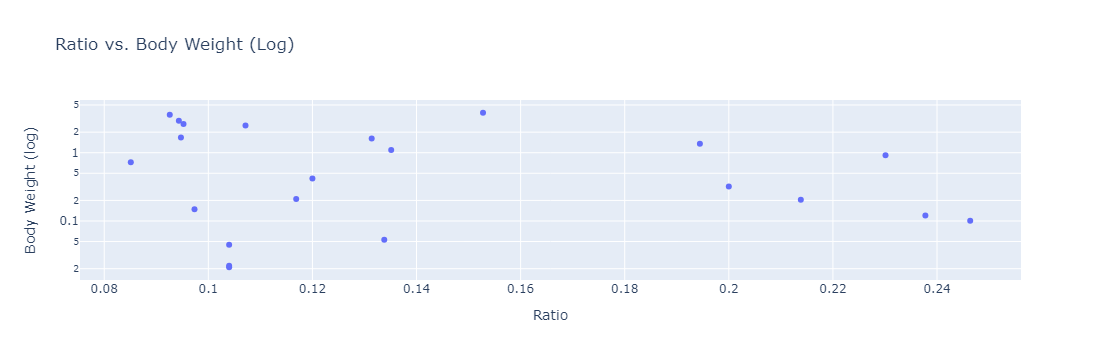

In [125]:

# Filter the DataFrame to remove rows with NaN values in 'Ratio' and 'TotalSleep' columns
df_div_cleaned = df_div.dropna(subset=['Ratio', 'TotalSleep'])

# Filter rows with 'BodyWt' less than 20
df_div_cleaned = df_div_cleaned[(df_div_cleaned['BodyWt'] < 20) & (df_div_cleaned['herbi']==1)]

# Plot the scatter plot
fig = px.scatter(df_div_cleaned, x='Ratio', y="BodyWt", 
                 title='Ratio vs. Body Weight (Log)', 
                 labels={'Total Sleep': 'Total Sleep', 'Ratio': 'Ratio', 'BodyWt': 'Body Weight (log)'},
                 log_y=True)  # Set log scale for y-axis (BodyWt)
fig.show()


In [126]:
df_div_cleaned.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Ratio
count,22.000000,22.000000,22.000000,22.000000,19.000000,19.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0,22.0,22.0,22.0,22.000000
mean,1.117182,7.265985,11.281818,12.718182,9.247368,1.684211,11.136364,70.227273,3.909091,1.954545,3.090909,0.0,1.0,0.0,0.0,0.140501
std,1.242250,6.821133,3.424372,3.424372,2.446623,1.011195,9.546854,70.386641,0.811177,0.998917,0.610159,0.0,0.0,0.0,0.0,0.053640
min,0.021000,0.330000,5.300000,7.400000,4.900000,0.500000,3.200000,16.000000,2.000000,1.000000,2.000000,0.0,1.0,0.0,0.0,0.085106
25%,0.127000,1.360000,8.650000,9.900000,7.450000,0.900000,6.075000,25.000000,3.250000,1.000000,3.000000,0.0,1.0,0.0,0.0,0.099009
50%,0.574000,5.600000,12.000000,12.000000,10.200000,1.500000,7.550000,29.000000,4.000000,2.000000,3.000000,0.0,1.0,0.0,0.0,0.118442
75%,1.657500,11.925000,14.100000,15.350000,11.000000,2.400000,12.700000,106.500000,4.000000,2.000000,3.000000,0.0,1.0,0.0,0.0,0.184028
max,3.850000,24.000000,16.600000,18.700000,12.300000,3.400000,40.000000,229.000000,5.000000,5.000000,5.000000,0.0,1.0,0.0,0.0,0.246377


• For the missing herbis we have, we see that most values are in between (0.1 and 0.2) lets put those.

In [127]:
import numpy as np

# Filter rows where 'herbi' is 1 and 'Ratio' is NaN
mask = (df_div['herbi'] == 1) & (df_div['Ratio'].isna())

# Generate uniformly distributed random values between 0.1 and 0.2 for the filtered rows
random_values = np.random.uniform(0.1, 0.2, size=np.sum(mask))

# Fill NaN values in the 'Ratio' column with the generated random values
df_div.loc[mask, 'Ratio'] = random_values

In [128]:
df_div[df_div["Ratio"].isna()]

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Animal_Name,Ratio
63,Potto,Perodicticus,Primates,lc,1.100,105.2,11.0,13.0,NaN,NaN,32.4,170.0,2.0,2.0,2.0,0,0,0,1,Potto,NaN
65,Raccoon,Procyon,Carnivora,NaN,4.288,39.2,12.5,11.5,NaN,NaN,13.7,63.0,2.0,2.0,2.0,1,0,0,0,Raccoon,NaN
72,Slow loris,Nyctibeus,Primates,NaN,1.400,12.5,11.0,13.0,NaN,NaN,12.7,90.0,2.0,2.0,2.0,1,0,0,0,loris,NaN


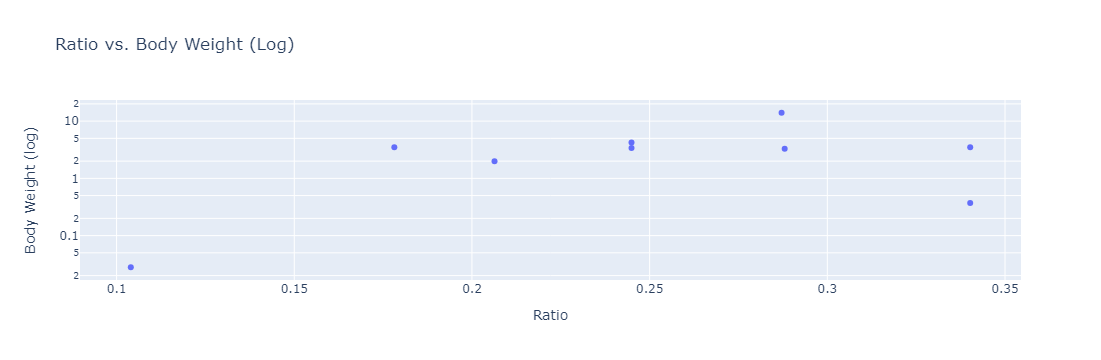

In [129]:

# Filter the DataFrame to remove rows with NaN values in 'Ratio' and 'TotalSleep' columns
df_div_cleaned = df_div.dropna(subset=['Ratio', 'TotalSleep'])

# Filter rows with 'BodyWt' less than 20
df_div_cleaned = df_div_cleaned[(df_div_cleaned['BodyWt'] < 20) & (df_div_cleaned['carni']==1)]

# Plot the scatter plot
fig = px.scatter(df_div_cleaned, x='Ratio', y="BodyWt", 
                 title='Ratio vs. Body Weight (Log)', 
                 labels={'Total Sleep': 'Total Sleep', 'Ratio': 'Ratio', 'BodyWt': 'Body Weight (log)'},
                 log_y=True)  # Set log scale for y-axis (BodyWt)
fig.show()

In [130]:
df_div_cleaned.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Ratio
count,9.000000,9.000000,9.000000,9.000000,7.000000,7.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,9.0,9.000000
mean,3.812000,26.600000,13.544444,10.455556,10.028571,3.785714,13.077778,53.444444,1.666667,1.333333,1.222222,1.0,0.0,0.0,0.0,0.248205
std,4.093637,23.491701,4.540130,4.540130,3.573380,2.050552,11.167450,33.264512,1.000000,0.500000,0.666667,0.0,0.0,0.0,0.0,0.077057
min,0.028000,0.300000,6.300000,4.600000,4.800000,1.300000,2.900000,14.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.104000
25%,2.000000,10.800000,10.100000,6.600000,7.300000,2.650000,4.500000,25.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.206349
50%,3.380000,17.500000,12.500000,11.500000,10.900000,3.100000,9.800000,60.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.244898
75%,3.500000,44.500000,17.400000,13.900000,12.800000,5.100000,15.000000,63.000000,2.000000,2.000000,1.000000,1.0,0.0,0.0,0.0,0.288000
max,14.000000,70.000000,19.400000,17.700000,14.300000,6.600000,34.000000,120.000000,4.000000,2.000000,3.000000,1.0,0.0,0.0,0.0,0.340206


In [131]:
# Filter rows where 'herbi' is 1 and 'Ratio' is NaN
mask = (df_div['carni'] == 1) & (df_div['Ratio'].isna())

# Generate uniformly distributed random values between 0.1 and 0.2 for the filtered rows
random_values = np.random.uniform(0.206, 0.288, size=np.sum(mask))

# Fill NaN values in the 'Ratio' column with the generated random values
df_div.loc[mask, 'Ratio'] = random_values

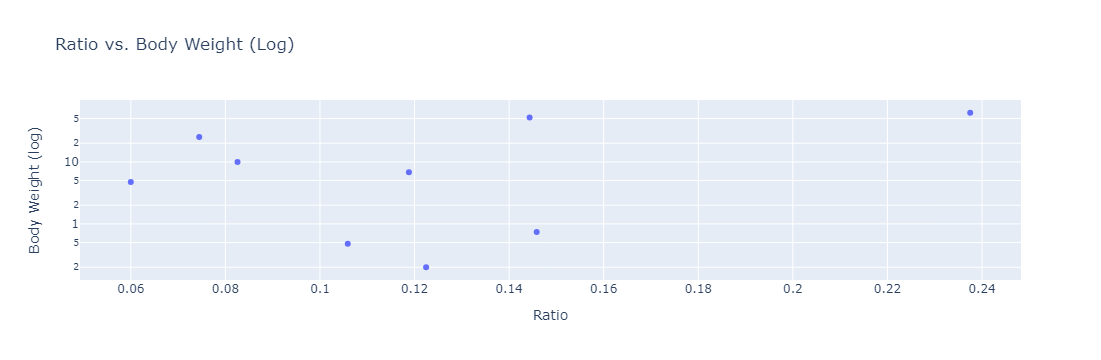

In [132]:
# Filter the DataFrame to remove rows with NaN values in 'Ratio' and 'TotalSleep' columns
df_div_cleaned = df_div.dropna(subset=['Ratio', 'TotalSleep'])

# Filter rows with 'BodyWt' less than 20
df_div_cleaned = df_div_cleaned[(df_div_cleaned['Order'] == "Primates") & (df_div_cleaned['omni'] == 1)]

# Plot the scatter plot
fig = px.scatter(df_div_cleaned, x='Ratio', y="BodyWt", 
                 title='Ratio vs. Body Weight (Log)', 
                 labels={'Total Sleep': 'Total Sleep', 'Ratio': 'Ratio', 'BodyWt': 'Body Weight (log)'},
                 log_y=True)  # Set log scale for y-axis (BodyWt)
fig.show()

In [133]:
df_div_cleaned.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni,Ratio
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,9.0,9.000000
mean,18.045333,259.166667,10.500000,13.500000,9.388889,1.233333,33.644444,182.444444,2.444444,2.444444,2.444444,0.0,0.0,0.0,1.0,0.121316
std,23.570542,420.295878,2.554897,2.554897,2.468018,0.450000,27.456106,45.869683,1.236033,1.130388,1.236033,0.0,0.0,0.0,0.0,0.052833
min,0.200000,5.000000,8.000000,7.000000,6.100000,0.600000,10.400000,120.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.060000
25%,0.743000,20.000000,9.600000,13.900000,8.300000,0.900000,20.200000,161.000000,2.000000,2.000000,2.000000,0.0,0.0,0.0,1.0,0.082569
50%,6.800000,115.000000,9.800000,14.200000,9.100000,1.200000,27.000000,170.000000,2.000000,2.000000,2.000000,0.0,0.0,0.0,1.0,0.118812
75%,25.235000,180.000000,10.100000,14.400000,9.700000,1.400000,30.200000,210.000000,4.000000,3.000000,4.000000,0.0,0.0,0.0,1.0,0.144330
max,62.000000,1320.000000,17.000000,16.000000,15.200000,1.900000,100.000000,267.000000,4.000000,4.000000,4.000000,0.0,0.0,0.0,1.0,0.237500


In [134]:
# Filter rows where 'herbi' is 1 and 'Ratio' is NaN
mask = (df_div['omni'] == 1) & (df_div['Ratio'].isna())

# Generate uniformly distributed random values between 0.1 and 0.2 for the filtered rows
random_values = np.random.uniform(0.0825, 0.144, size=np.sum(mask))

# Fill NaN values in the 'Ratio' column with the generated random values
df_div.loc[mask, 'Ratio'] = random_values

• Now we just need to infer Dreaming from Ratio

In [135]:
# Identify rows where 'Dreaming' is NaN
nan_dreaming_mask = df_div['Dreaming'].isna()

# Calculate the product of 'Ratio' and 'TotalSleep' for the corresponding rows
product_ratio_totalsleep = df_div['Ratio'] * df_div['TotalSleep']

# Assign the calculated values to the 'Dreaming' column for the rows where 'Dreaming' is NaN
df_div.loc[nan_dreaming_mask, 'Dreaming'] = product_ratio_totalsleep[nan_dreaming_mask]

In [136]:
#Done ! 
df_div.isna().sum()

Species          0
Genus            0
Order            0
Conservation    16
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming     23
Dreaming         0
LifeSpan         0
Gestation        0
Predation        0
Exposure         0
Danger           0
carni            0
herbi            0
insecti          0
omni             0
Animal_Name      0
Ratio            0
dtype: int64

• This is the only column we want to encode so far as it the best one to decompose in our dataset.

### II.iii Removing unnecessary columns

Some of the columns are not worth keeping because either:
- they have too many different values (eg: species or genus contain as many different values as rows)
- they have too many missing values that we can not fill up (eg: conservation)
- they are a repetition of another column (eg: 'NonDreaming' is just the time of 'TotalSleep' less 'Dreaming' time)

In [137]:
#We remove the unnecessary columns
columns_to_drop = ['Species', 'Genus', 'Order', 'Awake', 'NonDreaming', 'Animal_Name', 'Ratio', 'Conservation']
df_div.drop(columns=columns_to_drop, inplace=True)
df_clean = df_div.copy()
df_clean.head(7)


,BodyWt,BrainWt,TotalSleep,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,carni,herbi,insecti,omni
0,6654.000,5712.00,3.3,1.523077,38.6,645.0,3.0,5.0,3.0,0,1,0,0
1,1.000,6.60,8.3,2.000000,4.5,42.0,3.0,1.0,3.0,0,0,0,1
2,0.044,0.33,8.7,0.904800,4.5,25.0,4.0,1.0,3.0,0,0,0,1
3,3.380,44.50,12.5,3.061224,14.0,60.0,1.0,1.0,1.0,1,0,0,0
4,0.920,5.70,16.6,3.819770,7.1,25.0,5.0,2.0,3.0,0,1,0,0
5,2547.000,4603.00,3.9,1.800000,69.0,624.0,3.0,5.0,4.0,0,1,0,0
6,25.235,180.00,9.4,0.700000,27.0,180.0,4.0,4.0,4.0,0,0,0,1


## III Model Training

•  As we previously discussed, we decided to tackle this problem as a regression problem to tackle any continuous value.

•  As we don't have much data and not very strong correlations between values, we tried several ML methods first to tune the parameters. Then we performed a cross-evaluation to decide which model was more performent and thus best to keep.

•  We will start by building the model for 'Dreaming' target variable and then we will do the same for 'TotalSleep'

### III.i Model to predict 'Dreaming' variable

In [138]:
#Split the Data
X = df_div.drop(columns=['Dreaming'])  # We keep all features that we haven't dropped
y = df_div['Dreaming']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


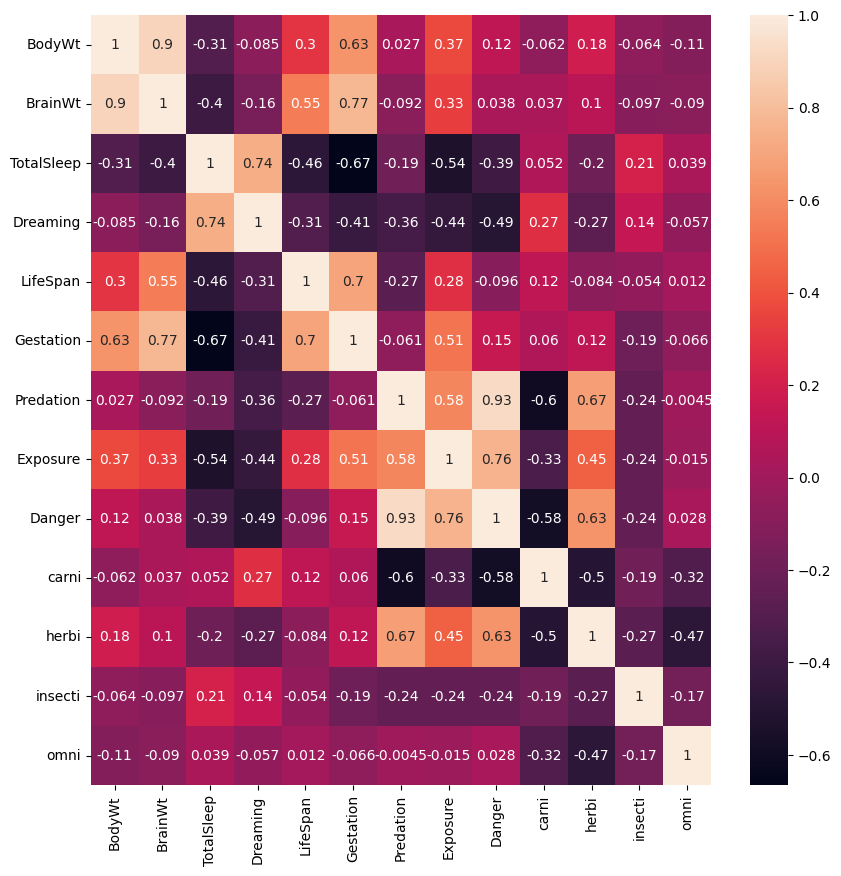

In [139]:
plt.figure(figsize = (10,10))
sns.heatmap(df_div.corr(), annot = True)
plt.show()

We decided to train the data using 9 different Machine Learning models: Linear Regression, Random Forest, Gradient Boosting, SVR, K-Nearest Neighbour Gaussian Process Regression, XGBREGRESSOR, SVM and Neural Network. We will evaluate them by measuring the Mean Squared Error(MSE) and the Mean Absolute Error (MAE).

Then we will choose the 5 top most performant models for the Cross Evaluation and final pick of the most performant model.

#### Linear Regression

In [140]:

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse_linear_regression = mean_squared_error(y_test, y_pred)
mae_linear_regression = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_linear_regression}")
print(f"Mean Absolute Error: {mae_linear_regression}")


Mean Squared Error: 7.271601323422183
Mean Absolute Error: 1.1306929059883946


#### Random Forest

In [141]:
#Random Forest Method


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse_random_forest = mean_squared_error(y_test, y_pred)
mae_random_forest = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_random_forest}")
print(f"Mean Absolute Error: {mae_random_forest}")


Mean Squared Error: 0.361866389743439
Mean Absolute Error: 0.49670135570353463


#### Gradient Boosting

In [142]:
#Gradient Boosting Regressor Model


model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse_gradient_boosting = mean_squared_error(y_test, y_pred)
mae_gradient_boosting = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_gradient_boosting}")
print(f"Mean Absolute Error: {mae_gradient_boosting}")


Mean Squared Error: 0.48511259171558874
Mean Absolute Error: 0.5576453948624702


#### SVR

In [143]:
#SVR


#Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = SVR(kernel='rbf', C=3.0, epsilon=0.0001) #Weel tried different values we could also try a custom kern
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluations
mse_SVR = mean_squared_error(y_test, y_pred)
mae_SVR = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_SVR}")
print(f"Mean Absolute Error: {mae_SVR}")


Mean Squared Error: 0.7209604583961338
Mean Absolute Error: 0.55526086340091


#### K-Nearest Neighbour

In [144]:

#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = KNeighborsRegressor(n_neighbors=3, weights='distance')
# we tried several values of n_neighbors but as there are not many
# animals linked to each other 3 neighbors seems good.
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse_KNN = mean_squared_error(y_test, y_pred)
mae_KNN = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_KNN}")
print(f"Mean Absolute Error: {mae_KNN}")


Mean Squared Error: 0.6032879767260818
Mean Absolute Error: 0.5672148015787906


#### Gaussian Process Regression

In [145]:
#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


kernel = 1.0 * RBF(length_scale=1.0)
model = GaussianProcessRegressor(kernel=kernel, alpha=0.5)
model.fit(X_train_scaled, y_train)
y_pred, std_dev = model.predict(X_test_scaled, return_std=True)

# Evaluation
mse_Gaussian = mean_squared_error(y_test, y_pred)
mae_Gaussian = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_Gaussian}")
print(f"Mean Absolute Error: {mae_Gaussian}")

Mean Squared Error: 0.5299735338633003
Mean Absolute Error: 0.5140180109400401


#### XGBREGRESSOR

In [146]:
#XGBREGRESSOR : gradoptimize gradient boosting

#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse_XGB = mean_squared_error(y_test, y_pred)
mae_XGB = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_XGB}")
print(f"Mean Absolute Error: {mae_XGB}")


Mean Squared Error: 0.3496791887553423
Mean Absolute Error: 0.5120953664129747


#### SVM

In [147]:
#SVM : Similar to SVR , looks for the hyper plane that best fits the data


#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = SVR(kernel='rbf', C=5.0, epsilon=0.05)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse_SVM = mean_squared_error(y_test, y_pred)
mae_SVM = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_SVM}")
print(f"Mean Absolute Error: {mae_SVM}")


Mean Squared Error: 0.6489942659122764
Mean Absolute Error: 0.5556256323900111


#### Neural Network

In [148]:
#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = MLPRegressor(hidden_layer_sizes=(100, 60), activation='tanh', solver='adam', 
                     alpha=0.01, batch_size='auto', learning_rate='adaptive', 
                     learning_rate_init=0.001, max_iter=10000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse_NN = mean_squared_error(y_test, y_pred)
mae_NN = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse_NN}")
print(f"Mean Absolute Error: {mae_NN}")


Mean Squared Error: 0.23832109244286126
Mean Absolute Error: 0.4001832971491708


• As per the MSE and MAE, the top 5 methods are :

In [149]:
print("Neural Network")
print("Mean Squared Error :", mse_NN)
print("Mean Absolute Error:",mae_NN)
print()
print("Gradient Boosting (GB)")
print("Mean Squared Error :", mse_gradient_boosting)
print("Mean Absolute Error:",mae_gradient_boosting)
print()
print("Random Forest")
print("Mean Squared Error :", mse_random_forest)
print("Mean Absolute Error:",mae_random_forest)
print()
print("Gaussian Process Regression")
print("Mean Squared Error :", mse_Gaussian)
print("Mean Absolute Error:",mae_Gaussian)
print()
print("KNN")
print("Mean Squared Error :", mse_KNN)
print("Mean Absolute Error:",mae_KNN)
print()



Neural Network
Mean Squared Error : 0.23832109244286126
Mean Absolute Error: 0.4001832971491708

Gradient Boosting (GB)
Mean Squared Error : 0.48511259171558874
Mean Absolute Error: 0.5576453948624702

Random Forest
Mean Squared Error : 0.361866389743439
Mean Absolute Error: 0.49670135570353463

Gaussian Process Regression
Mean Squared Error : 0.5299735338633003
Mean Absolute Error: 0.5140180109400401

KNN
Mean Squared Error : 0.6032879767260818
Mean Absolute Error: 0.5672148015787906



We proceed to the cross evaluation of the 5 models in order to choose the most performant. Besides the MSE and MAE, we add the R2 Score and Pi-score to the evaluation tools.

### Cross evaluation

In [150]:
from sklearn.model_selection import cross_val_predict
#Let's perform cross-validation

# Define the models with specified parameters
models = {
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 60), activation='tanh', solver='adam', 
                                   alpha=0.01, batch_size='auto', learning_rate='adaptive', 
                                   learning_rate_init=0.001, max_iter=10000, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gaussian Process Regression": GaussianProcessRegressor(kernel=kernel, alpha=0.5),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=3, weights='distance')
}

# Perform cross-validation for each model
for name, model in models.items():
    # Perform 5-fold cross-validation for Mean Squared Error (MSE)
    mse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    mse_score = -mse_scores.mean()  # Calculate average MSE across folds

    # Perform 5-fold cross-validation for Mean Absolute Error (MAE)
    mae_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
    mae_score = -mae_scores.mean()  # Calculate average MAE across folds
    
    # Make predictions
    predictions = cross_val_predict(model, X, y, cv=10)
    
    # Calculate Pi-score
    prediction_variances = np.var(predictions)
    pi_score = prediction_variances.mean()
    
    # Perform 10-fold cross-validation for R2 score
    r2_scores = cross_val_score(model, X, y, cv=10, scoring='r2')
    r2_score_mean = r2_scores.mean()  # Calculate average R2 score across folds
    
     # Print the results
    print(f"Model: {name}")
    print(f"Mean Squared Error (MSE): {mse_score}")
    print(f"Mean Absolute Error (MAE): {mae_score}")
    print(f"Pi-score: {pi_score}")
    print(f"R2 Score: {r2_score_mean}")
    print()

Model: Neural Network
Mean Squared Error (MSE): 1.3784678347822688
Mean Absolute Error (MAE): 0.9035680942494896
Pi-score: 1.56619491135278
R2 Score: 0.09092406585630998

Model: Gradient Boosting
Mean Squared Error (MSE): 0.8006939068410593
Mean Absolute Error (MAE): 0.6793544699230086
Pi-score: 1.6187776931836102
R2 Score: 0.49163751291336294

Model: Random Forest
Mean Squared Error (MSE): 0.7003510291605812
Mean Absolute Error (MAE): 0.6419717126858947
Pi-score: 1.3128173106585268
R2 Score: 0.557194738220591

Model: Gaussian Process Regression
Mean Squared Error (MSE): 1.5747336366399265
Mean Absolute Error (MAE): 0.8906810067607053
Pi-score: 1.4459522202615465
R2 Score: 0.09154393107966866

Model: K-Nearest Neighbors
Mean Squared Error (MSE): 1.1524711954786484
Mean Absolute Error (MAE): 0.8396079862030218
Pi-score: 1.0768283410113821
R2 Score: 0.29485708674511046



### III.ii Model to predict 'TotalSleep' variable

Now we are going to do the same for 'TotalSleep' variable. 

First, we split the data:

In [151]:
#Split the Data
X = df_div.drop(columns=['TotalSleep'])  # We keep all features that we haven't dropped
y = df_div['TotalSleep']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


As a reminder, let's plot the correlation heatmap:

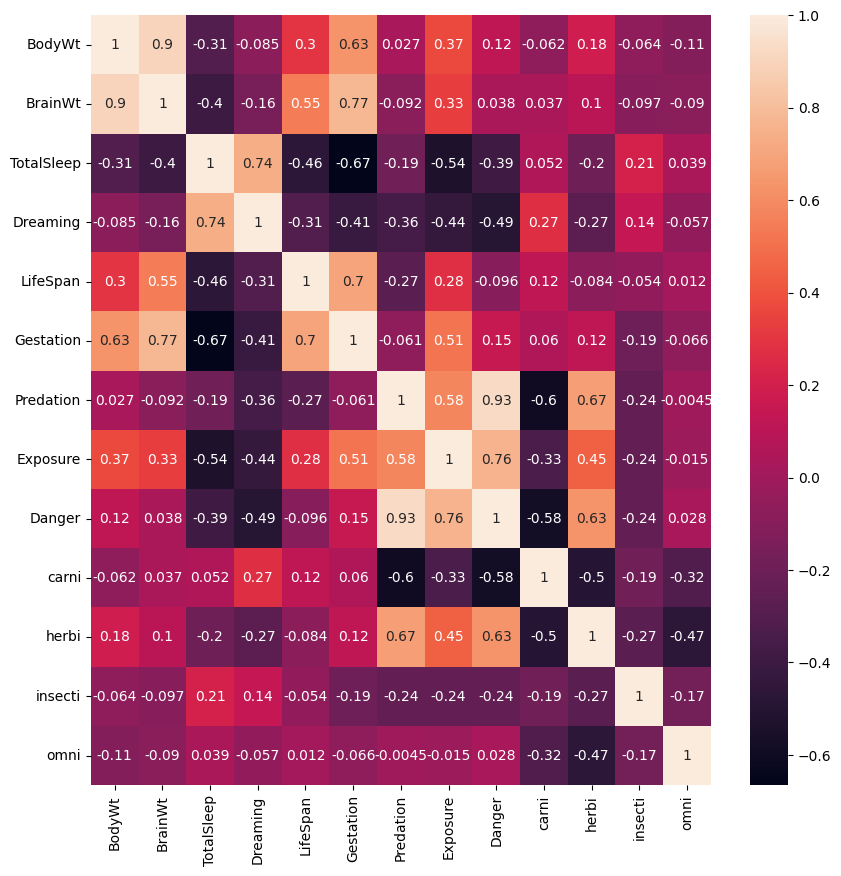

In [152]:
plt.figure(figsize = (10,10))
sns.heatmap(df_div.corr(), annot = True)
plt.show()

We can observe a sensibly stronger correlation between the target variable TotalSleep and the rest of variables, mainly with variables Gestation and Exposure. 

We decided to train the data again using the same 9 different Machine Learning models as for the targe variable Dreaming : Linear Regression, Random Forest, Gradient Boosting, SVR, K-Nearest Neighbour Gaussian Process Regression, XGBREGRESSOR, SVM and Neural Network. We will evaluate them by measuring the Mean Squared Error(MSE) and the Mean Absolute Error (MAE).

Then we will choose the 5 top most performant models for the Cross Evaluation and final pick of the most performant model.

### Linear Regression

In [153]:

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 6.538577214506291
Mean Absolute Error: 1.8303688773491875


### Random Forest

In [154]:
#Random Forest Method


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 5.414779777777763
Mean Absolute Error: 2.0859999999999967


### Gradient Boosting

In [155]:
#Gradient Boosting Regressor Model

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 4.80858944983579
Mean Absolute Error: 1.88121482693248


### SVR

In [156]:
#Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = SVR(kernel='rbf', C=3.0, epsilon=0.0001) #Weel tried different values we could also try a custom kern
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluations
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 8.140349162443462
Mean Absolute Error: 2.4176888389135662


### K-nearest neighbor

In [157]:

#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = KNeighborsRegressor(n_neighbors=3, weights='distance')
# we tried several values of n_neighbors but as they are not much
# animals link to each other 3 neighbors seems good.
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 8.453464294982503
Mean Absolute Error: 2.4219913435923153


### Gaussian Process Regression

In [158]:
#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


kernel = 1.0 * RBF(length_scale=1.0)
model = GaussianProcessRegressor(kernel=kernel, alpha=0.5)
model.fit(X_train_scaled, y_train)
y_pred, std_dev = model.predict(X_test_scaled, return_std=True)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 12.157188204578098
Mean Absolute Error: 2.5733928249248468


### XGBREGRESSOR

In [159]:
#XGBREGRESSOR : gradoptimize gradient boosting

#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 6.658992379089022
Mean Absolute Error: 2.1321302122539945


### SVM

Similar to SVR , looks for the hyper plane that best fits the data.

In [160]:
#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = SVR(kernel='rbf', C=5.0, epsilon=0.05)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 6.596444707333874
Mean Absolute Error: 2.1701231286220044


### Neural Networks

In [161]:
#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = MLPRegressor(hidden_layer_sizes=(100, 60), activation='tanh', solver='adam', 
                     alpha=0.01, batch_size='auto', learning_rate='adaptive', 
                     learning_rate_init=0.001, max_iter=10000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 10.358136848774691
Mean Absolute Error: 2.110545709068546


### Cross Evaluation

In [162]:
# We take once again the best methods for a cross validation. 
models = {
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 60), activation='tanh', solver='adam', 
                                   alpha=0.01, batch_size='auto', learning_rate='adaptive', 
                                   learning_rate_init=0.001, max_iter=10000, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),  # Linear Regression
    "Support Vector Machine": SVR(kernel='rbf')  # SVM
}

# Perform cross-validation for each model
for name, model in models.items():
    # Perform 10-fold cross-validation for Mean Squared Error (MSE)
    mse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    mse_score = -mse_scores.mean()  # Calculate average MSE across folds

    # Perform 10-fold cross-validation for Mean Absolute Error (MAE)
    mae_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
    mae_score = -mae_scores.mean()  # Calculate average MAE across folds
    
    # Make predictions
    predictions = cross_val_predict(model, X, y, cv=10)
    
    # Calculate Pi-score
    prediction_variances = np.var(predictions)
    pi_score = prediction_variances.mean()
    
    # Perform 10-fold cross-validation for R2 score
    r2_scores = cross_val_score(model, X, y, cv=10, scoring='r2')
    r2_score_mean = r2_scores.mean()  # Calculate average R2 score across folds
    
     # Print the results
    print(f"Model: {name}")
    print(f"Mean Squared Error (MSE): {mse_score}")
    print(f"Mean Absolute Error (MAE): {mae_score}")
    print(f"Pi-score: {pi_score}")
    print(f"R2 Score: {r2_score_mean}")
    print()

Model: Neural Network
Mean Squared Error (MSE): 17.842392718120482
Mean Absolute Error (MAE): 3.1109888041415226
Pi-score: 20.77023052344517
R2 Score: -0.30021536342634336

Model: Gradient Boosting
Mean Squared Error (MSE): 8.578330891577169
Mean Absolute Error (MAE): 2.2204137934588273
Pi-score: 14.26148249003149
R2 Score: 0.4008231497810934

Model: Random Forest
Mean Squared Error (MSE): 7.7705316527777795
Mean Absolute Error (MAE): 2.0636833333333335
Pi-score: 11.902092492535346
R2 Score: 0.4828946255560426

Model: Linear Regression
Mean Squared Error (MSE): 9.516098886406757
Mean Absolute Error (MAE): 2.1673874095417447
Pi-score: 20.43242216735535
R2 Score: 0.41693063639495936

Model: Support Vector Machine
Mean Squared Error (MSE): 14.788885447010395
Mean Absolute Error (MAE): 3.136910711319852
Pi-score: 1.7879763645004667
R2 Score: 0.06038935828450979



### Interpretation of Results

• During cross-validation, the dataset is split into multiple folds, and the model is trained and evaluated on each fold separately. This process introduces randomness in the data splitting, resulting in different subsets of data being used for training and testing in each fold.Giving a better idea of the actual MSE and MAE. 

• MSE penalizes outliers (because of the square) and we have a few. Also the R2_score is a better measure of reliability than a simple mean value prediction. 

• Random Forest model appears to perform the best for both target variables, as it has the lowest MSE and MAE, indicating better accuracy, and it also has a relatively high R2 score and a moderate Pi-score compared to other models. Therefore, we choose to deploy the **Random Forest Model**. Nevertheless, we should keep in mind that the model for the target variable Dreaming outperforms the one for TotalSleep accross all metrics. Therefore, the predictive performance of the model for Dreaming is much better than the one for TotalSleep.

• The main weaknesses of our dataset are that it is small (only 87 observations) and it contains many missing values, which compromises the performance of the ML models we built. As the values we found in other sources to complete the dataset were not coherent with the ones we already had, we decided to try and replace all the values in columns LifeSpan, BodyWt and Gestation. Our source was the website https://genomics.senescence.info/species. Nevertheless, this didn't improve the correlation of the three columns with the variables TotalSleep and Dreaming. Therefore, we decided against keeping the values. Instead, we completed the LifeSpan column using the same source, in an effort of preserving the integrity of the dataset as much as possible.